# **MASTER'S THESIS:**
# **APPLICATION OF MACHINE LEARNING ALGORITHMS WITHIN CREDIT RISK MODELLING**

**Author**: Petr Nguyen

The Home Equity dataset (HMEQ) contains characteristics and delinquency information about 5,960 home equity loans.

http://www.creditriskanalytics.net/datasets-private2.html

Columns:
- BAD: Target variable (default status)
- LOAN: Amount of the loan request (in USD)
- MORTDUE: Amount due on existing mortgage (in USD)
- VALUE: Value of current property (in USD)
- REASON: DebtCon = debt consolidation; HomeImp = home improvement
- JOB: Occupational categories
- YOJ: Years at present job
- DEROG: Number of major derogatory reports
- DELINQ: Number of delinquent credit lines
- CLAGE: Age of oldest credit line in months
- NINQ: Number of recent credit inquiries
- CLNO: Number of credit lines
- DEBTINC: Debt-to-income ratio

Import relevant libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import time
import math
import missingno
from itertools import combinations

from scipy.stats import chi2_contingency, ks_2samp, pointbiserialr, somersd
from imblearn.over_sampling import SMOTENC, ADASYN

from optbinning import BinningProcess

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,\
                            brier_score_loss, zero_one_loss, hamming_loss, jaccard_score,\
                            matthews_corrcoef, confusion_matrix, roc_curve, roc_auc_score
 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import shap

Parameters' initialization
- seed: in order to preserve the reproducibility of this Python notebook
- test_size, validation_size: percentage splits

In [9]:
seed = 42
test_size = 0.15
validation_size = test_size/(1 - test_size)

Reading data

In [10]:
data = pd.read_csv("./data/raw_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: './data/raw_data.csv'

## **Exploratory Data Analysis**

In [238]:
data

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


We can observe that we have combination of categorical and continuous features as well as some missing values.

In [239]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Duplication check

In [240]:
print(f"Duplicates check: {data.duplicated(subset = [col for col in data.columns if col != 'BAD']).sum()} duplicated rows.")

Duplicates check: 0 duplicated rows.


Obtaining lists of both categorical and continuous features

In [ ]:
def categorical_continuous_vars(df: pd.DataFrame, target:str = "BAD") -> tuple[list, list]:
    
    cat_vars = [col for col in df.columns if df[col].dtypes == "O" and col != target]
    cont_vars = [col for col in df.columns if col not in cat_vars + [target]]

    print(f"Categorical features: {', '.join(cat_vars)}")
    print(f"Continuous features: {', '.join(cont_vars)}")

    return (cat_vars, cont_vars)

In [ ]:
cat_vars, cont_vars = categorical_continuous_vars(data)

Categorical features: REASON, JOB
Continuous features: LOAN, MORTDUE, VALUE, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC


In [245]:
pd.get_dummies(data['JOB'], drop_first = False)

,Mgr,Office,Other,ProfExe,Sales,Self
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
5955,0,0,1,0,0,0
5956,0,0,1,0,0,0
5957,0,0,1,0,0,0
5958,0,0,1,0,0,0


In [269]:
cat_name = 'JOB'
temp = data.copy()
temp[cat_name] = temp[cat_name].fillna('N/A')
cats = list(temp[cat_name].unique())
dummies = pd.get_dummies(temp[cat_name], drop_first = False)
temp = temp.drop(cat_name, axis = 1)
temp = pd.concat((temp, dummies), axis = 1)
dis = pd.DataFrame(columns = cont_vars, index = cats)
for cont in cont_vars:
    temp_df = temp.copy()
    temp_df = temp_df[temp_df[cont].notna()]
    for cat in cats:
        dis.loc[cat, cont] = pointbiserialr(temp_df[cont], temp_df[cat])[0]
dis

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
Other,-0.039858,-0.257303,-0.242496,0.055727,0.041545,-0.0209,-0.060323,0.065307,-0.167407,0.043113
N/A,-0.044223,-0.046204,-0.068217,-0.016699,0.013701,-0.033449,-0.065693,-0.023985,-0.113539,-0.164286
Office,-0.01806,-0.069384,-0.058459,-0.03389,-0.053191,0.001469,-0.00144,-0.065621,-0.004579,0.028785
Sales,-0.044993,0.026044,0.015953,-0.038098,0.03111,-0.020494,0.025395,-0.03587,0.049203,0.057121
Mgr,0.018769,0.076101,0.045768,0.020681,0.037049,0.062004,-0.024026,0.072511,0.060891,0.065788
ProfExe,0.017488,0.261487,0.267842,-0.012299,-0.044839,-0.01578,0.112304,-0.063271,0.167121,-0.076119
Self,0.158452,0.108239,0.152323,-0.045626,-0.004378,0.021205,-0.011338,0.017533,0.031583,0.036723


In [266]:
diss = pd.melt(dis)

diss = pd.concat((pd.DataFrame({'category':cats * len(cont_vars)}), diss),axis=1)
diss['value'] = diss['value'].astype(float)
diss

<AxesSubplot:xlabel='value', ylabel='variable'>

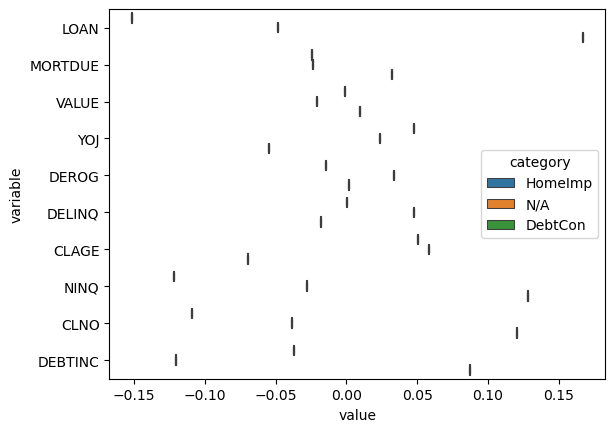

In [268]:
sns.boxplot(diss, x = 'value', y = 'variable', hue = 'category')

Dendrogram for visualization of the features that have strong nullity correlation in with hierarchical clustering.
- For instance, we can observe that features CLNO and CLAGE missing values are strongly correlated.

In [ ]:
def na_dendrogram(df:pd.DataFrame, export:bool = True):

    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'

    #True/False values indicating whether a column has some NA's.
    na_columns_indicators = df.describe(include = "all").T["count"] < df.shape[0]
    #Filtering the column names having NA's.
    na_columns = df.columns[na_columns_indicators]
    #Subsetting the data based on the NA's columns.
    final_df_dendogram = df[na_columns]

    #Plotting the dendrogram
    missingno.dendrogram(final_df_dendogram, orientation = "top", figsize = (10, 5), fontsize = 11)
    #plt.title("Dendrogram of variables having NA's", size = 13, fontweight = "bold")
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45, fontsize=14)

    plt.tight_layout()

    #Exporting the plot
    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/NA_Dendrogram.jpg", dpi = 300)
    
    plt.show()

NameError: name 'pd' is not defined

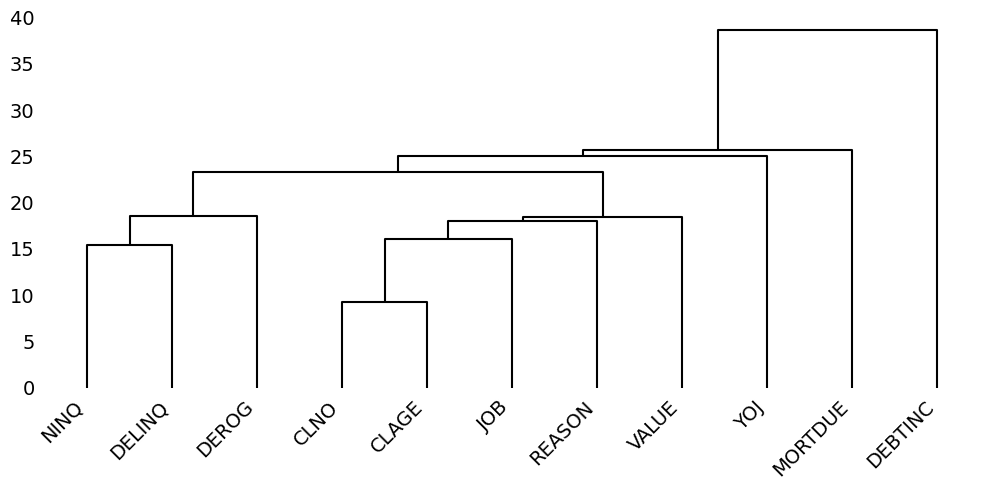

In [ ]:
na_dendrogram(data)

**Distribution of target variable**

In [97]:
def default_distribution_plot(df:pd.DataFrame, target:str = "BAD", export:bool = True):  

    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
    matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
    matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
    
    #Replacing the Booleans with non-default/default strings for visualization
    df_plot = df[[target]].copy().replace({0: "Non-default", 1: "Default"})

    #Figure's initialization
    plt.figure(figsize = (8, 6))
    
    #Default distribution
    sns.countplot(df_plot, x = target, palette = "BuPu",
                  order = list(df_plot[target].unique())[::-1])
    
    #plt.title("Default Distribution", fontsize = 13, fontweight= "bold")
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel(None)

    #Removing upper and right axes spines
    axes = plt.gca()
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    
    #Exporting plot
    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/Default_Distribution.jpg", dpi = 300)

    plt.show()

- As can be seen, the class is imbalanced (circa 80% loans haven't defaulted, whereas 20% have defaulted).
- One would say to treat this issue with undersampling or oversampling.

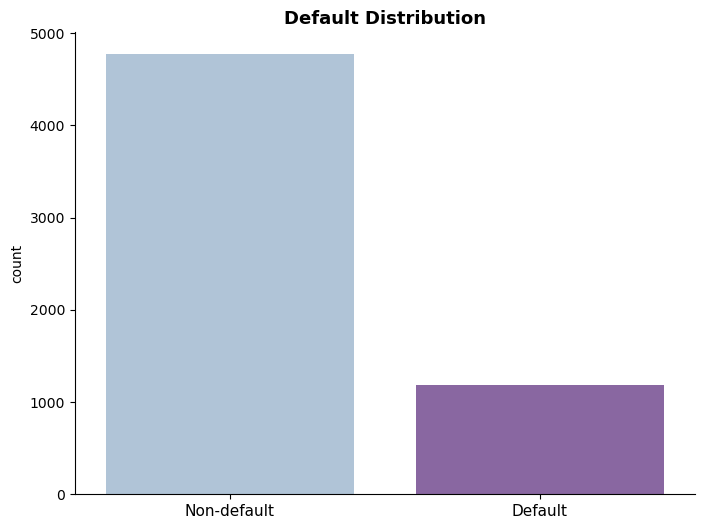

In [98]:
default_distribution_plot(data)

**Distribution of continuous features**
- Conditional on the target variable.
- Distrubtion visualized either with boxplots, violionplots or histograms.

In [99]:
def continuous_distribution_plot(df: pd.DataFrame, cont_vars: list,
                                 plot_type: str, target: str = "BAD", 
                                 export: bool = True):

    #Possible plot types
    plot_types = {"boxplot": sns.boxplot,
                  "violinplot": sns.violinplot,
                  "histogram": sns.histplot}

    #Plot type parameter check
    if plot_type not in plot_types.keys():
        raise ValueError(f"Invalid plot type. Please, select one of these available plot types: {','.join([key for key in plot_types.keys()])}")

    #Plot either boxplots or violinplots
    if plot_type in ["boxplot", "violinplot"]:
        
        #replace 0/1's with (Non)-default texts for visualization's sake.
        df_plot = df.copy()
        df_plot[target] = df_plot[target].replace({0: "Non-default", 1: "Default"})

        #Figure's and axes' initialization
        fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 20))

        for ax, var in zip(axs.ravel(), cont_vars):
            
            #Boxplot/violinplot
            plot_types[plot_type](data = df_plot, x = target, y = var, ax = ax,
                                  palette = "BuPu", order = ["Non-default", "Default"])

            ax.set_title(f"Distribution of {var}", size = 17)
            ax.tick_params(axis = "both", which = "major", labelsize = 15)
            ax.set(xlabel = None)
            ax.set(ylabel = None)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
        
        plt.tight_layout()
        #fig.suptitle("Distribution of Continuous Features", fontsize = 16, fontweight = "bold")
        #fig.subplots_adjust(top=0.95)
        #Exporting the plots
        if export:
            os.makedirs("./plots/", exist_ok = True)
            plt.savefig(f"./plots/Continuous_Features_Distribution_{plot_type.capitalize()}s.jpg", dpi = 300)
        plt.show()


    #Plot histograms
    elif plot_type == "histogram":
        def integer_formatter(x, pos):
            return f'{int(x)}'

        #Figure's and axes' initialization
        fig, axs = plt.subplots(nrows = len(cont_vars), ncols = 2, figsize = (12, 25))

        #Column index
        col_ind = 0
        #Axis index (if the value is even, the plot will be located on the left side, otherwise on the right side)
        axis_count = 0

        for ax in axs.ravel():

            #Accessing the feature name.
            var = cont_vars[col_ind]
            #Subsetting the data based on the feature.
            var_series = df[var]

            #Calculating the bin size for given feature ensuring that both conditional plots (left and right) will have the same number of bins.
                #Using rule of thumb (Scott, 1979) - https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
       
            R = var_series.max() - var_series.min() #Range of the feature's values
            n = len(var_series) #Number of feature's values
            sigma = var_series.std() #Standard deviation of the feature's values
        
            #Number of bins
            no_bins = int(R*(n**(1/3))/(3.49*sigma))

            #The left side (even axis_count) depicts the features' distribution conditional on the non-default cases.
            if axis_count % 2 == 0:
                #Subsetting the data for non-default cases only.
                df_subset= df.query(f"{target} == 0")
                #Number of missing values within given feature
                no_missings = df_subset[var].isna().sum()
                #Percentage of missing values within subset of given feature (i.e., percentage of missing values of given feature within the non-default cases)
                pct_missings = no_missings/df_subset.shape[0] * 100

                #Histogram with kernel density function
                plot_types[plot_type](data = df_subset, x = var, ax = ax, bins = no_bins,
                                binrange = ((var_series.min(), var_series.max())), #binrange to ensure that both left and right plot will have the same data range.
                                kde = True, color = "lightblue")
 
                ax.set_title(f"Distribution of {var} (Non-default cases)", size = 17)
                ax.tick_params(axis = "both", which = "major", labelsize = 15, rotation = 30)
                ax.set(xlabel = None)
                ax.set_ylabel(ax.get_ylabel(), fontsize=15)
                ax.xaxis.set_major_formatter(ticker.FuncFormatter(integer_formatter))
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)

                #Inserting a text box with an information about the missing values.
                ax.text(0.7, 0.9, f"Number of NA's: {no_missings} ({pct_missings:.1f}%)",
                       horizontalalignment = "center", verticalalignment = "center",
                       fontsize = 14,
                       transform = ax.transAxes, bbox = dict(facecolor = "pink", alpha = 0.3))

            #The right side (odd axis_count) depicts the features' distribution conditional on the default cases.
            else:
                #Subsetting the data for default cases only.
                df_subset = df.query(f"{target} == 1")
                #Number of missing values within given feature
                no_missings = df_subset[var].isna().sum()
                #Percentage of missing values within subset of given feature (i.e., percentage of missing values of given feature within the default cases)
                pct_missings = no_missings/df_subset.shape[0] * 100

                #Histogram with kernel density function
                sns.histplot(data = df_subset, x = var, ax = ax, bins = no_bins,
                                binrange = ((var_series.min(), var_series.max())), #binrange to ensure that both left and right plot will have the same data range.
                                kde = True, color = "mediumpurple")
                
                ax.set_title(f"Distribution of {var} (Default cases)", size = 17)
                ax.tick_params(axis = "both", which = "major", labelsize = 15, rotation = 30)
                ax.set(xlabel = None)
                ax.set_ylabel(ax.get_ylabel(), fontsize=15)
                ax.xaxis.set_major_formatter(ticker.FuncFormatter(integer_formatter))
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)

                #Inserting a text box with an information about the missing values.
                ax.text(0.7, 0.9, f"Number of NA's: {no_missings} ({pct_missings:.1f}%)",
                        horizontalalignment = "center", verticalalignment = "center",
                        fontsize = 14,
                        transform = ax.transAxes, bbox = dict(facecolor = "pink", alpha = 0.3))
                
                #Proceeding with the next feature
                col_ind += 1

            #Switching to the left/right side of the figure
            axis_count +=1
        
        plt.tight_layout()
        #fig.suptitle("Distribution of Continuous Features", fontsize = 16, fontweight = "bold")
        #fig.subplots_adjust(top=0.95)
        
        #Exporting the plots
        if export:
            os.makedirs("./plots/", exist_ok = True)
            plt.savefig(f"./plots/Continuous_Features_Distribution_{plot_type.capitalize()}s.jpg", dpi = 300)
    
        plt.show()

As can be seen, the features contain various outliers as well as missing values.
- Further, most of the features' distributions are positively skewed and don't follow normal distribution. 

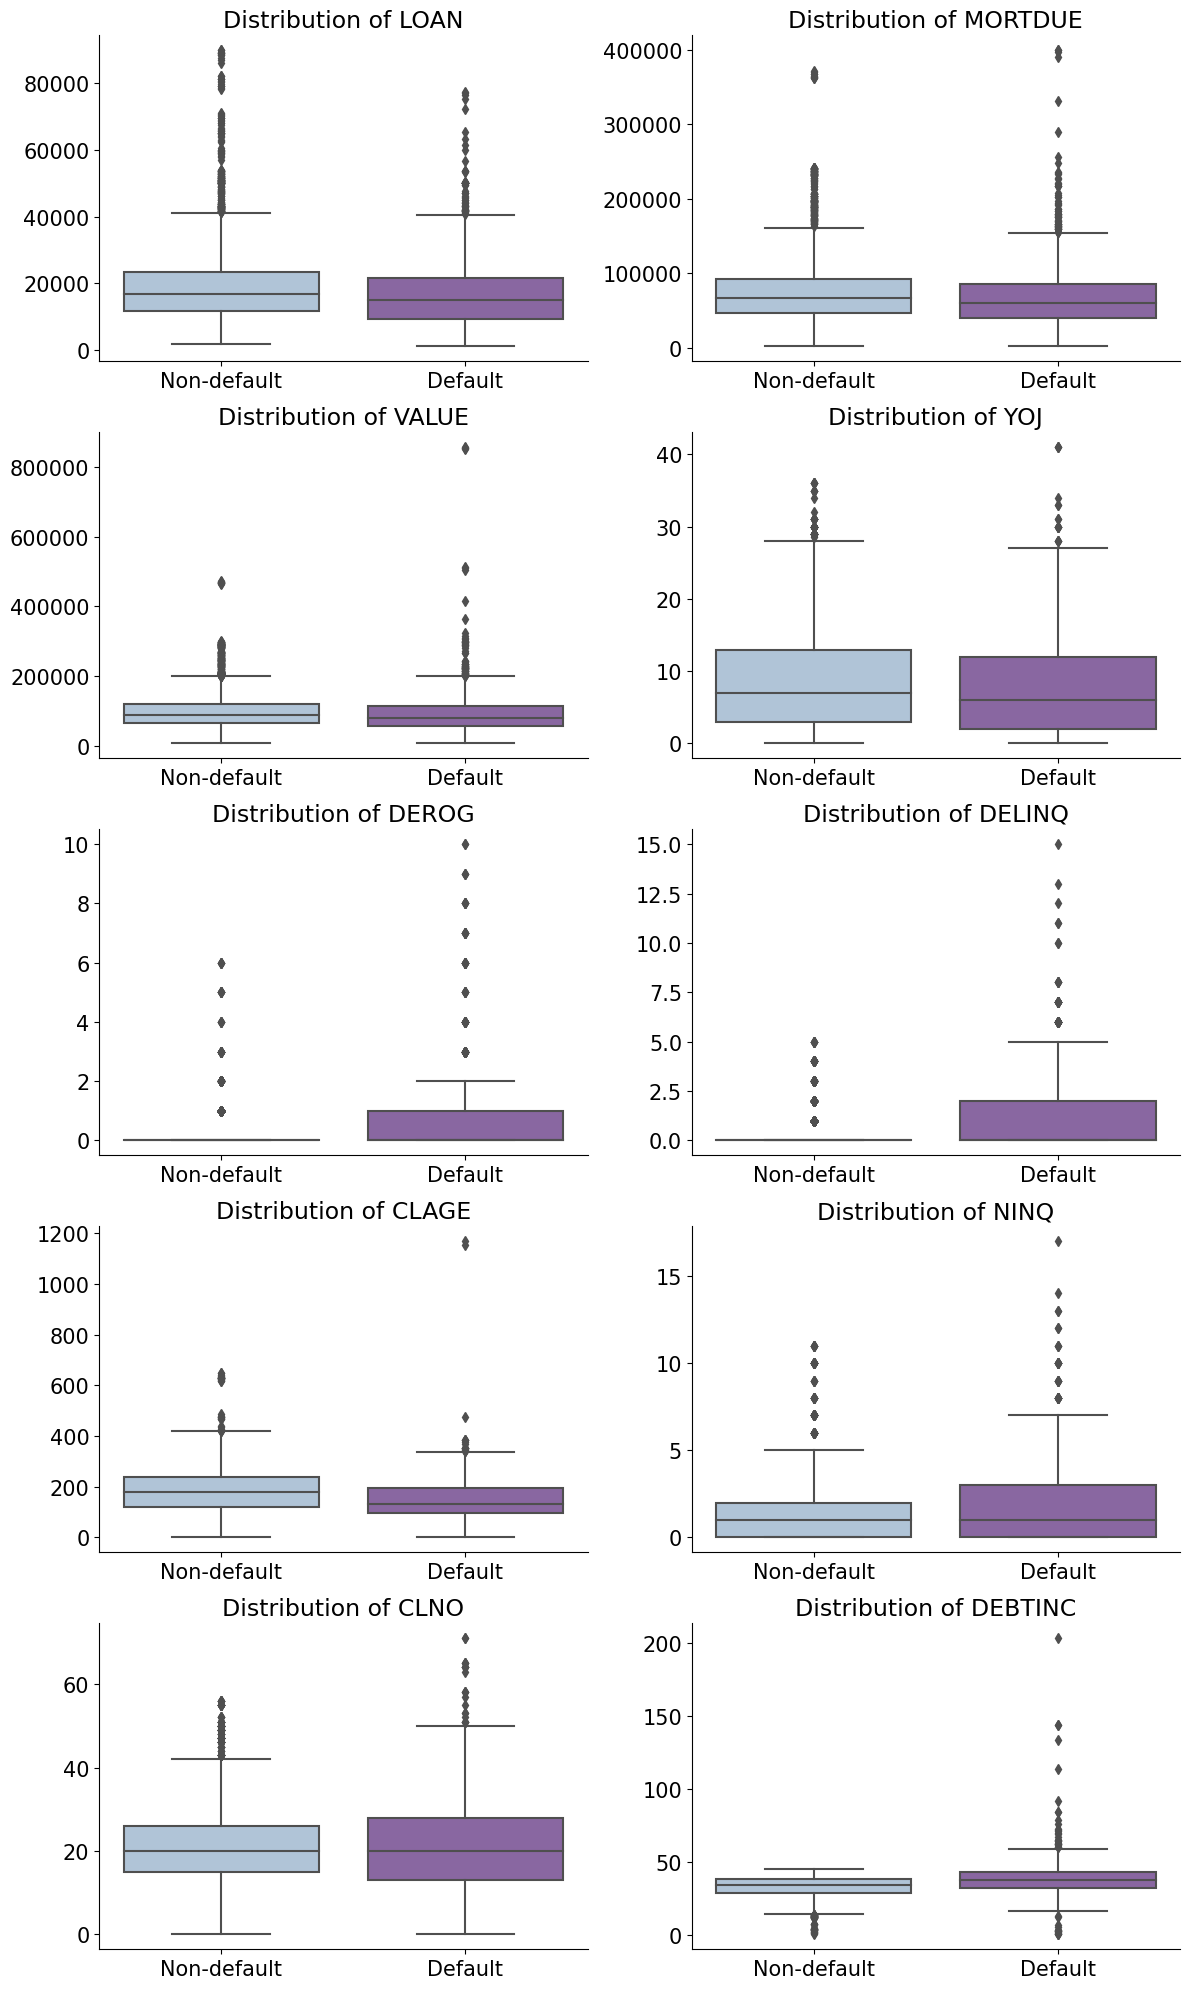

In [100]:
continuous_distribution_plot(data, cont_vars, plot_type = "boxplot")

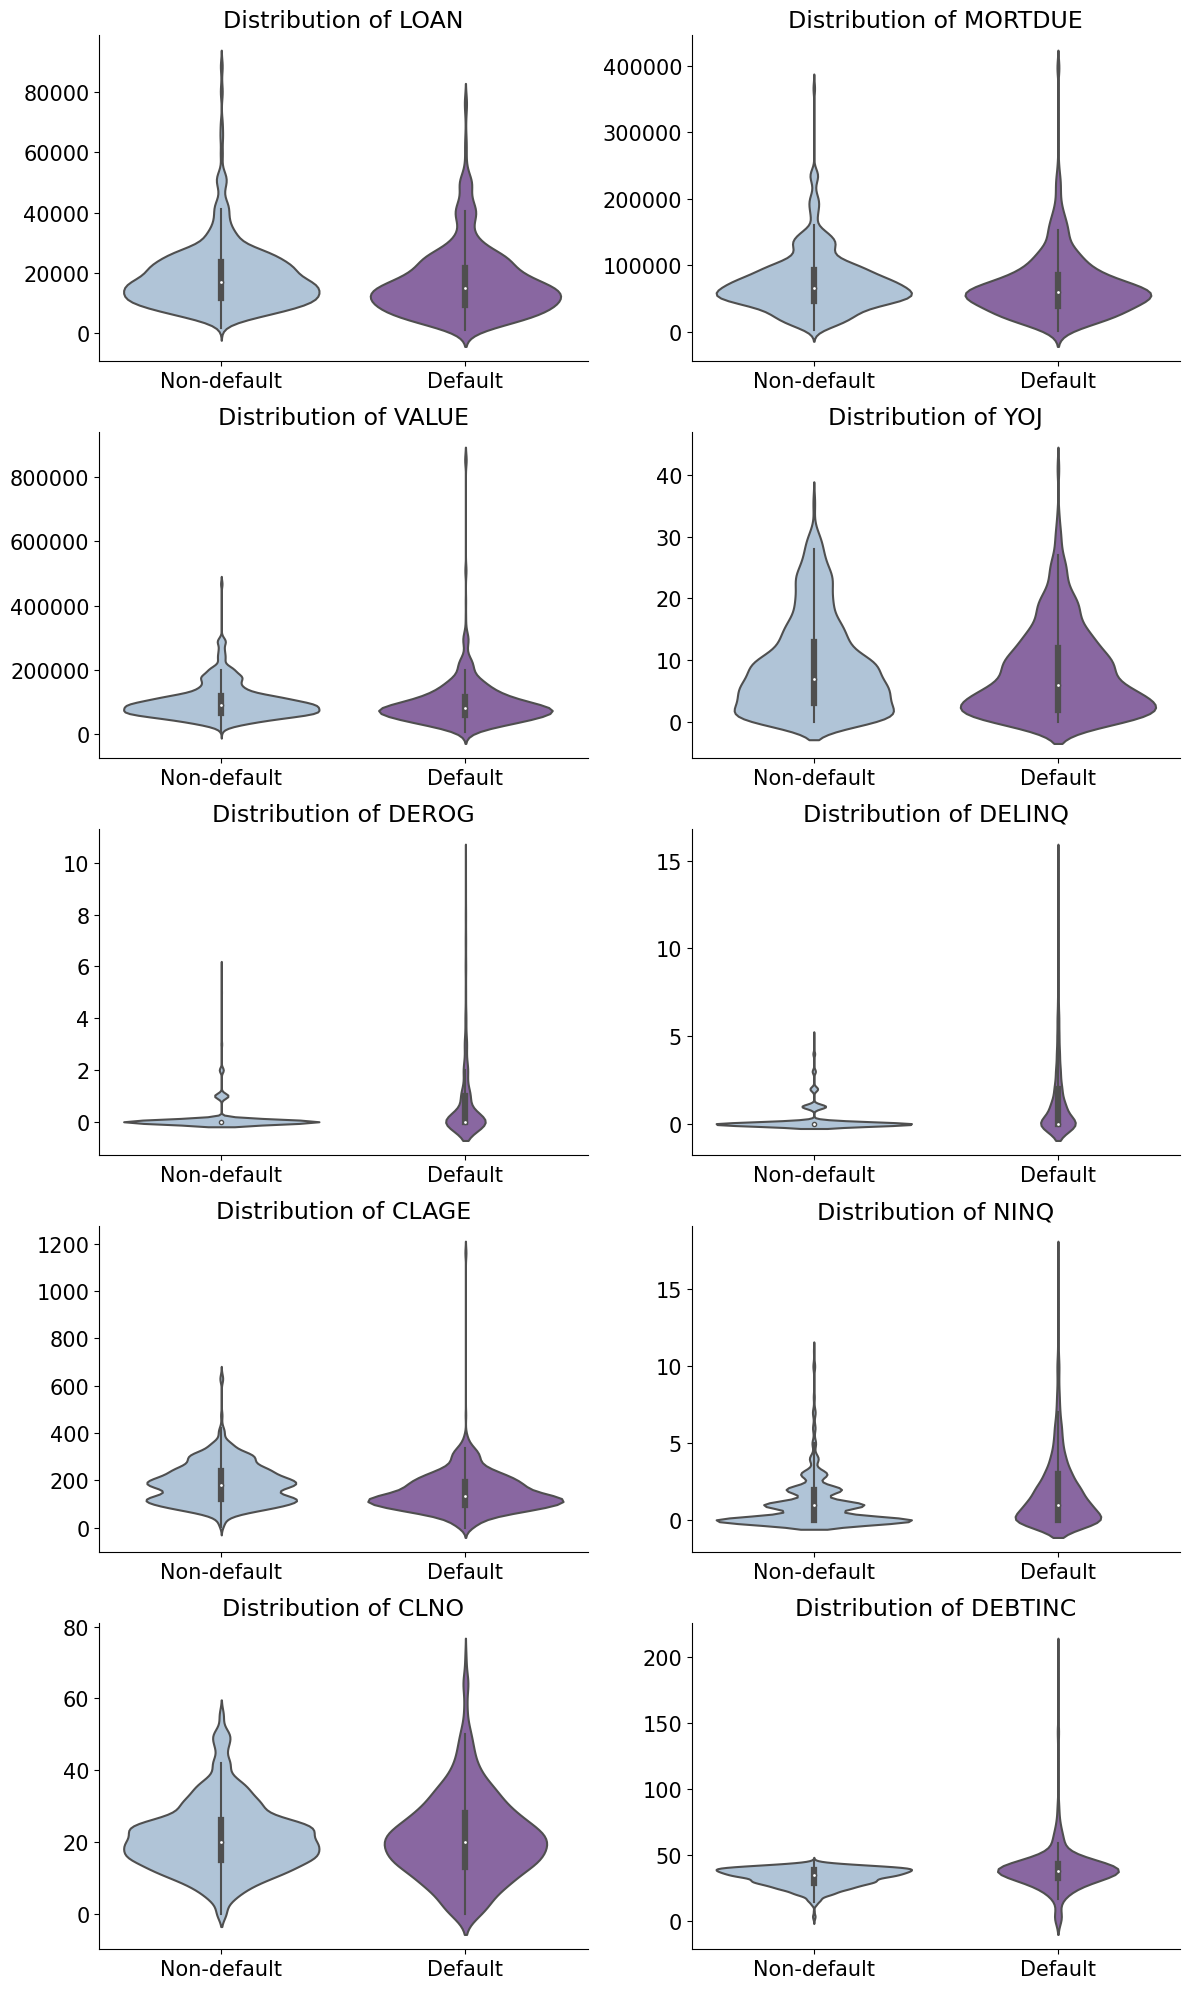

In [101]:
continuous_distribution_plot(data, cont_vars, plot_type = "violinplot")

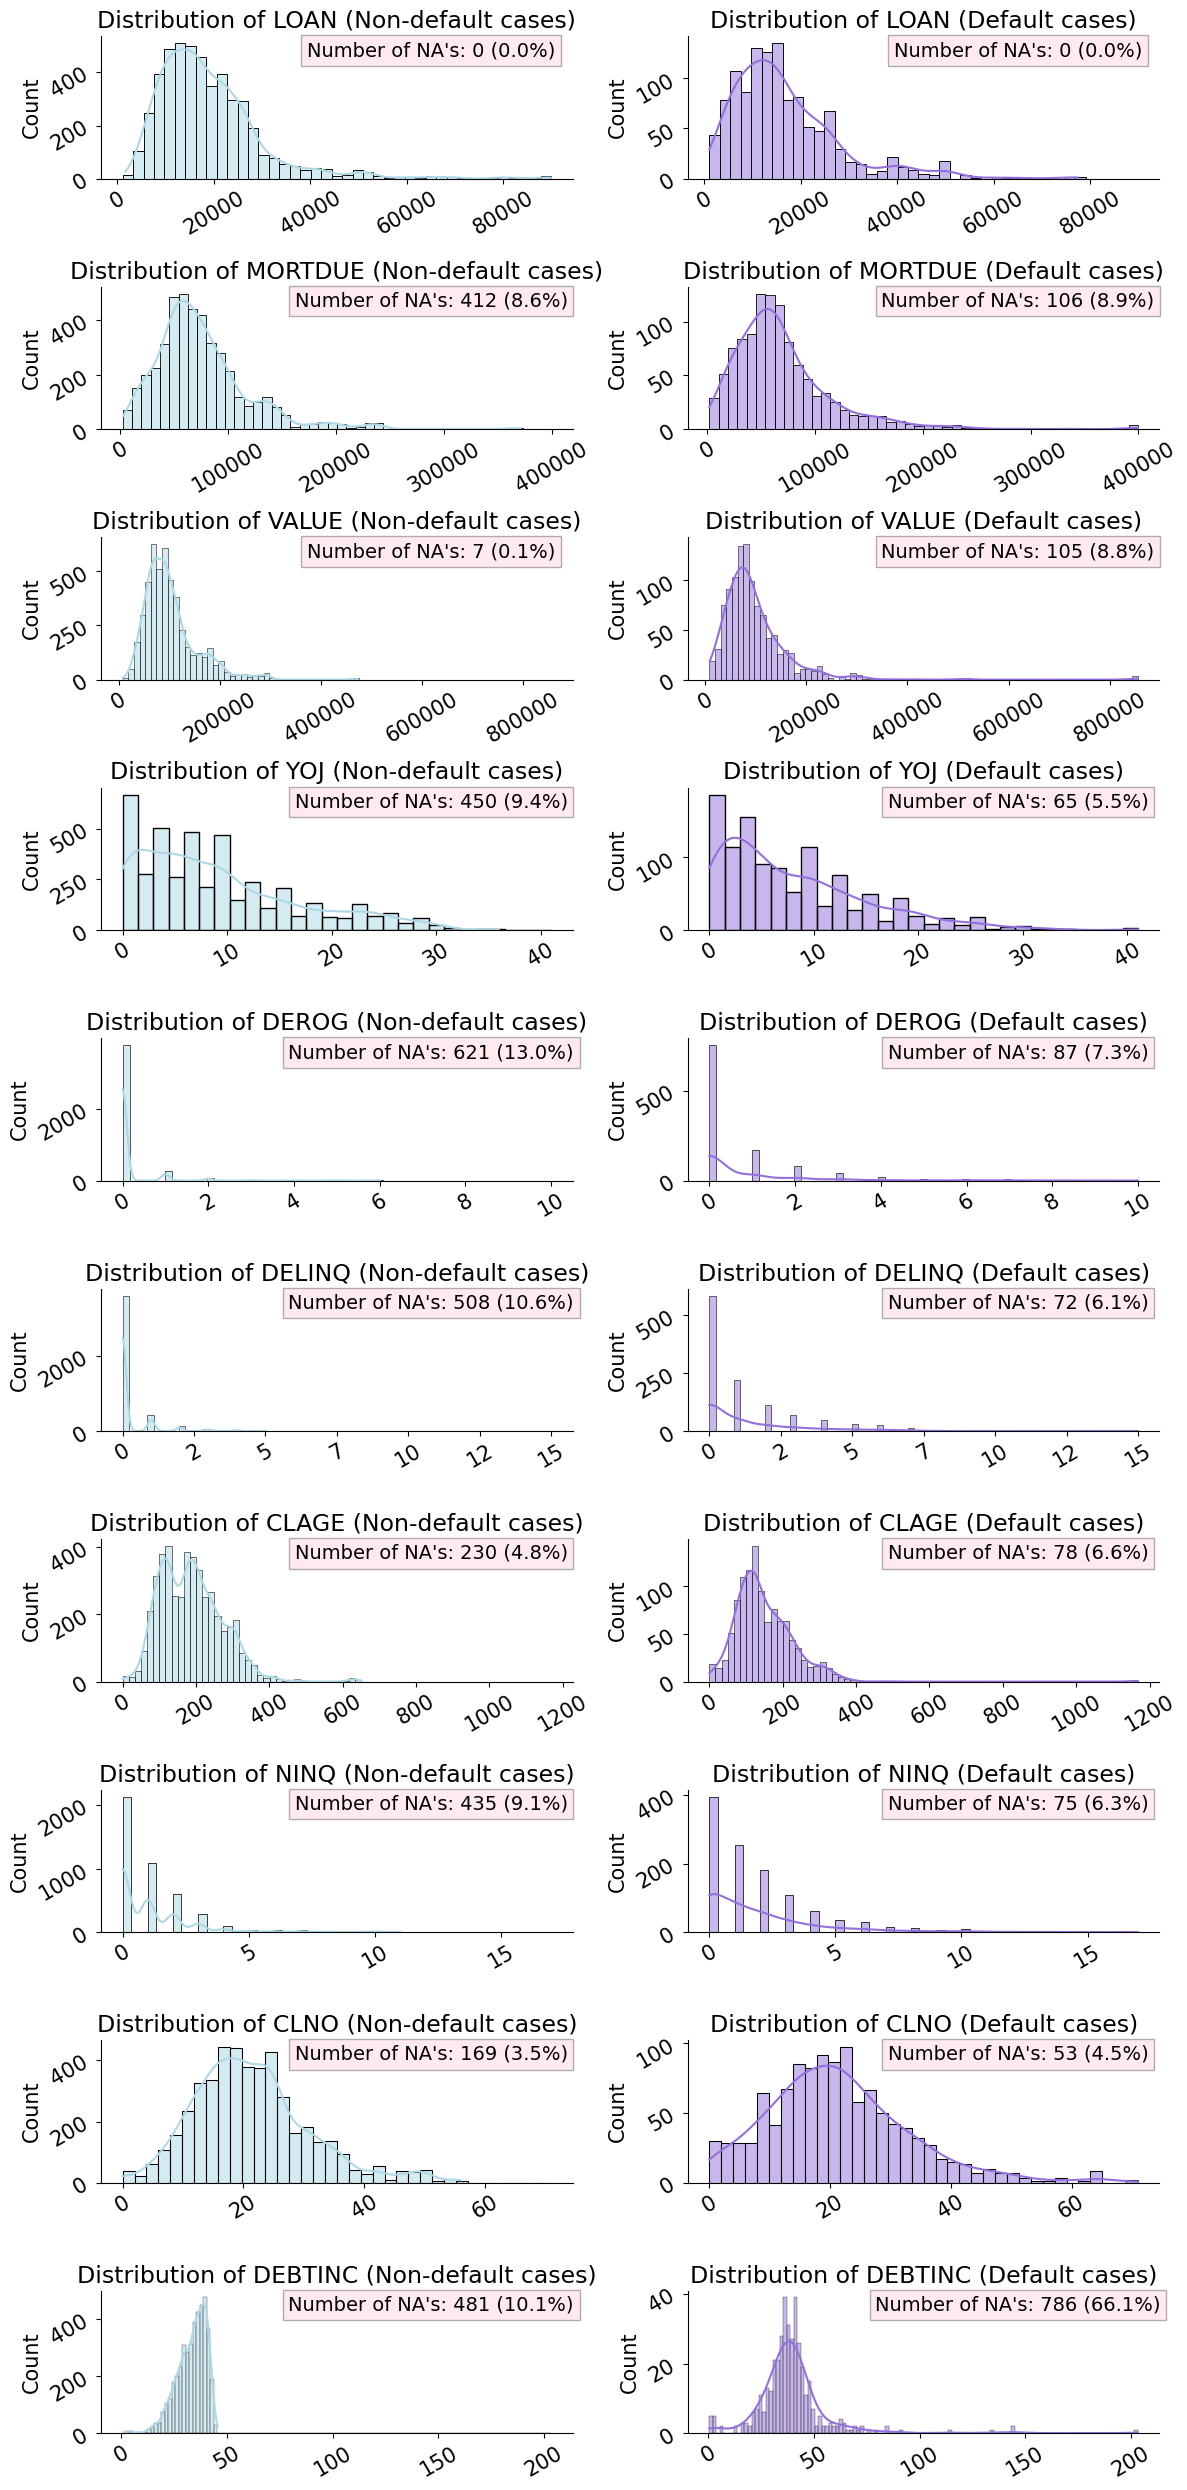

In [102]:
continuous_distribution_plot(data, cont_vars, plot_type = "histogram")

In [103]:
target ='BAD'
x = pd.DataFrame(index = cont_vars, columns = ["# of NA's (Y=0)", "# of NA's (Y=1)",  "% of NA's (Y=0)", "% of NA's (Y=1)"])
for cont in cont_vars:
    x.loc[cont, "# of NA's (Y=1)"] = data.query(f"{target} == 1")[cont].isna().sum()
    x.loc[cont, "# of NA's (Y=0)"] = data.query(f"{target} == 0")[cont].isna().sum()
    x.loc[cont, "% of NA's (Y=1)"] = round(x.loc[cont, "# of NA's (Y=1)"]/data.query(f"{target} == 1").shape[0] * 100, 4)
    x.loc[cont, "% of NA's (Y=0)"] = round(x.loc[cont, "# of NA's (Y=0)"]/data.query(f"{target} == 0").shape[0] * 100, 4)

x

,# of NA's (Y=0),# of NA's (Y=1),% of NA's (Y=0),% of NA's (Y=1)
LOAN,0,0,0.0,0.0
MORTDUE,412,106,8.6355,8.9151
VALUE,7,105,0.1467,8.831
YOJ,450,65,9.432,5.4668
DEROG,621,87,13.0161,7.3171
DELINQ,508,72,10.6477,6.0555
CLAGE,230,78,4.8208,6.5601
NINQ,435,75,9.1176,6.3078
CLNO,169,53,3.5422,4.4575
DEBTINC,481,786,10.0817,66.106


In [104]:
x

,# of NA's (Y=0),# of NA's (Y=1),% of NA's (Y=0),% of NA's (Y=1)
LOAN,0,0,0.0,0.0
MORTDUE,412,106,8.6355,8.9151
VALUE,7,105,0.1467,8.831
YOJ,450,65,9.432,5.4668
DEROG,621,87,13.0161,7.3171
DELINQ,508,72,10.6477,6.0555
CLAGE,230,78,4.8208,6.5601
NINQ,435,75,9.1176,6.3078
CLNO,169,53,3.5422,4.4575
DEBTINC,481,786,10.0817,66.106


In [105]:
target ='BAD'
cat = 'JOB'
temp_df = data.copy()
temp_df[cat] = temp_df[cat].fillna('N/A') 
x = pd.DataFrame(index = list(temp_df[cat].unique()), columns = ["# (Y=0)", "# (Y=1)",  "% (Y=0)", "% (Y=1)"])

for cate in x.index:
    x.loc[cate, "# (Y=1)"] = temp_df.query(f"{target} == 1 and {cat} == '{cate}'").shape[0]
    x.loc[cate, "# (Y=0)"] = temp_df.query(f"{target} == 0 and {cat} == '{cate}'").shape[0]
    x.loc[cate, "% (Y=1)"] = round(x.loc[cate, "# (Y=1)"]/temp_df.query(f"{target} == 1").shape[0], 4)* 100
    x.loc[cate, "% (Y=0)"] = round(x.loc[cate, "# (Y=0)"]/temp_df.query(f"{target} == 0").shape[0] , 4)* 100


x

,# (Y=0),# (Y=1),% (Y=0),% (Y=1)
Other,1834,554,38.44,46.59
N/A,256,23,5.37,1.93
Office,823,125,17.25,10.51
Sales,71,38,1.49,3.2
Mgr,588,179,12.32,15.05
ProfExe,1064,212,22.3,17.83
Self,135,58,2.83,4.88


In [106]:
target ='BAD'
cat = 'REASON'
temp_df = data.copy()
temp_df[cat] = temp_df[cat].fillna('N/A') 
x = pd.DataFrame(index = list(temp_df[cat].unique()), columns = ["# (Y=0)", "# (Y=1)",  "% (Y=0)", "% (Y=1)"])

for cate in x.index:
    x.loc[cate, "# (Y=1)"] = temp_df.query(f"{target} == 1 and {cat} == '{cate}'").shape[0]
    x.loc[cate, "# (Y=0)"] = temp_df.query(f"{target} == 0 and {cat} == '{cate}'").shape[0]
    x.loc[cate, "% (Y=1)"] = round(x.loc[cate, "# (Y=1)"]/temp_df.query(f"{target} == 1").shape[0], 4)* 100
    x.loc[cate, "% (Y=0)"] = round(x.loc[cate, "# (Y=0)"]/temp_df.query(f"{target} == 0").shape[0] , 4)* 100


x

,# (Y=0),# (Y=1),% (Y=0),% (Y=1)
HomeImp,1384,396,29.01,33.31
N/A,204,48,4.28,4.04
DebtCon,3183,745,66.72,62.66


In [107]:
from scipy.stats import shapiro, jarque_bera, anderson, kstest, normaltest
def jarque_bera_test(data, col):
    stat, p = jarque_bera(data[col])
    alpha = 0.05
    if p > alpha:
        return True
    else:
        return False
def shapiro_test(data, col):
    stat, p = shapiro(data[col])
    alpha = 0.05
    if p > alpha:
        return True
    else:
        return False

def ks_test(data, col):
    result = kstest(data[col], 'norm')
    if result.pvalue > 0.05:
        return True
    else:
        return False
    

print('Significance level = 0.05')
print('   - True = feature is normally distributen on given significance level.')
print('   - False = feature is not normally distributen on given significance level.')
def dag_per_test(data, col):
    stat, p = normaltest(data[col])
    if p > 0.05:
        return True
    else:
        return False

x = pd.DataFrame(columns = ['Shapiro-Wilk', 'Jarque-Bera', 'Kolmogorov-Smirnov', "D'Agostino-Pearson"], index = cont_vars)

for cont in cont_vars:
    
    x.loc[cont, 'Shapiro-Wilk'] = shapiro_test(data, cont)
    x.loc[cont, 'Jarque-Bera'] = jarque_bera_test(data, cont)
    x.loc[cont, 'Kolmogorov-Smirnov'] = ks_test(data, cont)
    x.loc[cont, "D'Agostino-Pearson"] = dag_per_test(data, cont)
x


Significance level = 0.05
   - True = feature is normally distributen on given significance level.
   - False = feature is not normally distributen on given significance level.


,Shapiro-Wilk,Jarque-Bera,Kolmogorov-Smirnov,D'Agostino-Pearson
LOAN,False,False,False,False
MORTDUE,True,False,False,False
VALUE,True,False,False,False
YOJ,True,False,False,False
DEROG,True,False,False,False
DELINQ,True,False,False,False
CLAGE,True,False,False,False
NINQ,True,False,False,False
CLNO,True,False,False,False
DEBTINC,True,False,False,False


**Distribution of categorical features**

In [108]:
def categorical_distribution_plot(df: pd.DataFrame, cat_vars: list,
                                  target: str = "BAD", export: bool = True):
    
    #Figure's and axes' initialization
    fig, axs = plt.subplots(nrows = len(cat_vars),ncols = 2, figsize = (11, 10))

    #Column index
    col_ind = 0
    #Axis index (if the value is even, the plot will be located on the left side, otherwise on the right side)
    axis_count = 0

    for ax in axs.ravel():

        #Accessing the feature name
        var = cat_vars[col_ind]
        #Subsetting the data based on the feature with subsequent replacing missing values with N/A's strings (for visualization's sake).
        var_target_df = df[[var, target]].copy().fillna("N/A")
        
        #If the feature has some missing values, put the N/A category at the end of the plot.
        if var_target_df.query(f"{var} == 'N/A'").shape[0] != 0:
            categories = [cat for cat in var_target_df[var].unique() if cat != "N/A"] + ["N/A"]
        else:
            categories = var_target_df[var].unique()

        #The left side (even axis_count) depicts the features' distribution conditional on the non-default cases.
        if axis_count % 2 == 0:

            sns.countplot(data = var_target_df.query(f"{target} == 0"), x = var,
                          ax = ax, order = categories, color = "lightblue")

            ax.set_title(f"Distribution of {var} (Non-default cases)", size = 17)
            ax.tick_params(axis = "both", which = "major", labelsize = 15)
            ax.tick_params(axis = "x", rotation = 30, which = "major", labelsize = 15)
            ax.set(xlabel = None)
            ax.set_ylabel(ax.get_ylabel(), fontsize=15)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
                        
        
        #The right side (odd axis_count) depicts the features' distribution conditional on the default cases.
        else:
            
            sns.countplot(data = var_target_df.query(f"{target} == 1"), x = var,
                          ax = ax, order = categories, color = "mediumpurple")

            ax.set_title(f"Distribution of {var} (Default cases)", size = 17)
            ax.tick_params(axis = "both", which = "major", labelsize = 15)
            ax.tick_params(axis = "x", rotation = 30, which = "major", labelsize = 15)
            ax.set_ylabel(ax.get_ylabel(), fontsize=15)
            ax.set(xlabel = None)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            #Proceeding with the next feature
            col_ind += 1

        #Switching to the left/right side of the figure
        axis_count += 1

    plt.tight_layout()


    #fig.suptitle("Distribution of Categorical Features", fontsize = 16, fontweight = "bold")
    #fig.subplots_adjust(top=0.90)

    #Exporting the plots
    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/Categorical_Features_Distribution.jpg", dpi = 300)
        
    plt.show()

As can be seen, within the REASON feature, the relative distributions conditional on default status don't differ that much.
- Whereas, within the JOB feature, we can observe some relative differences (for instance within Self or NA (missing value) category)

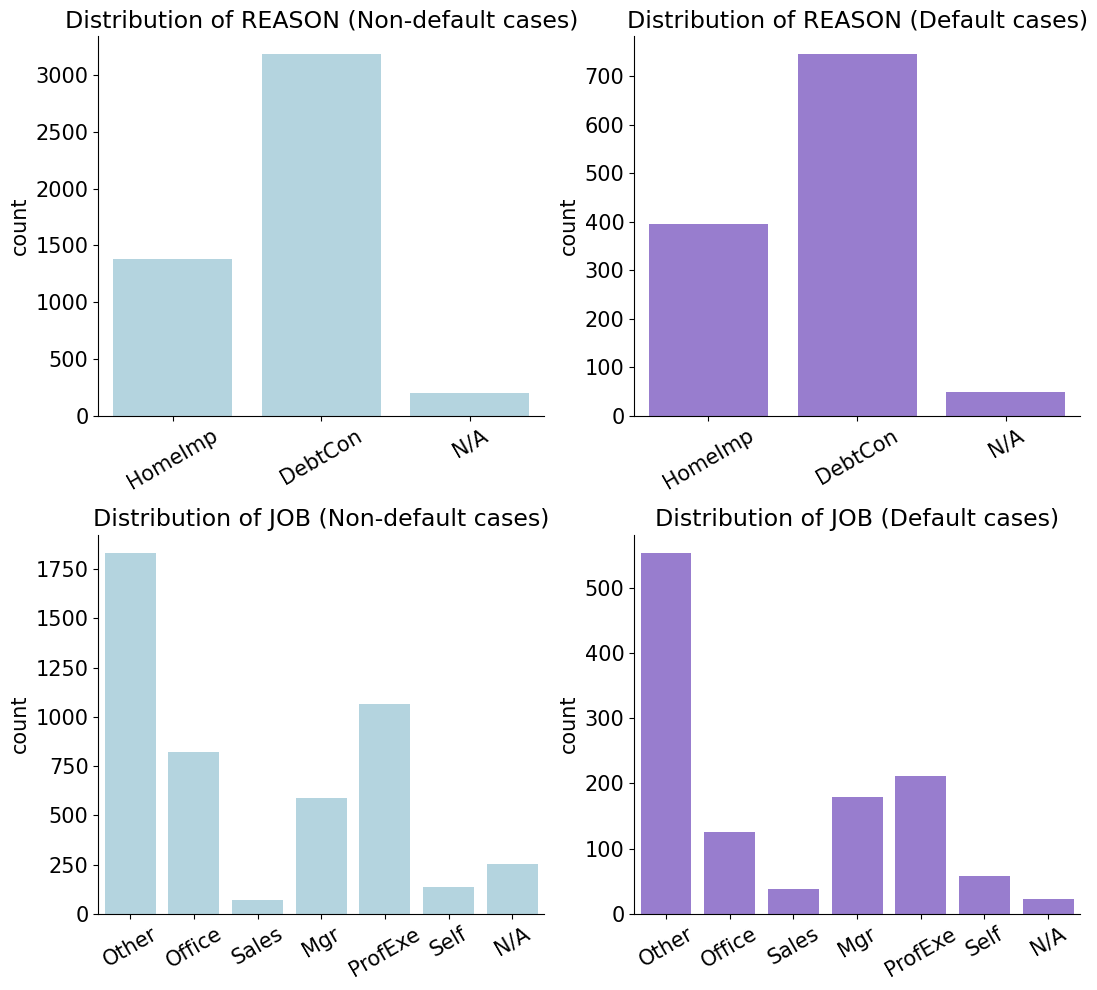

In [109]:
categorical_distribution_plot(data, cat_vars)

**Correlation between continuous features**
- We can also check for multicolinearity.
- One would use traditional Pearson correlation coefficient - however, I don't deem it approriate, since it can only measure linear relationship and also assumes that the data are normally distributed (which is not true in this case).
- Thus, I use Spearman correlation coefficient instead, which considers the nonlinearity.
$$\rho_{spearman} = 1-\frac{6 \sum_{i=1}^{n} d^2_i}{n \left(n^2-1 \right)}$$

In [225]:
def spearman_corr_matrix_plot(df: pd.DataFrame, cont_vars: list, export: bool = True):

    #Figure's initialization
    plt.figure(figsize = (13,12))

    #Corelation matrix heatmap
    sns.heatmap(df[cont_vars].corr(method = "spearman"), vmin = -1, vmax = 1,
                mask = np.triu(np.ones_like(df[cont_vars].corr())),
                annot = True, cmap  = "coolwarm",  fmt = ".3f",
                xticklabels = cont_vars, yticklabels = cont_vars,
                annot_kws={"size": 15})

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()

    #Exporting the plots
    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/Spearman_Correlation_Matrix_Continuous_Features.jpg", dpi = 300)
    
    plt.show()


We can see that the VALUE and MORTDUE are strongly and positively associated.

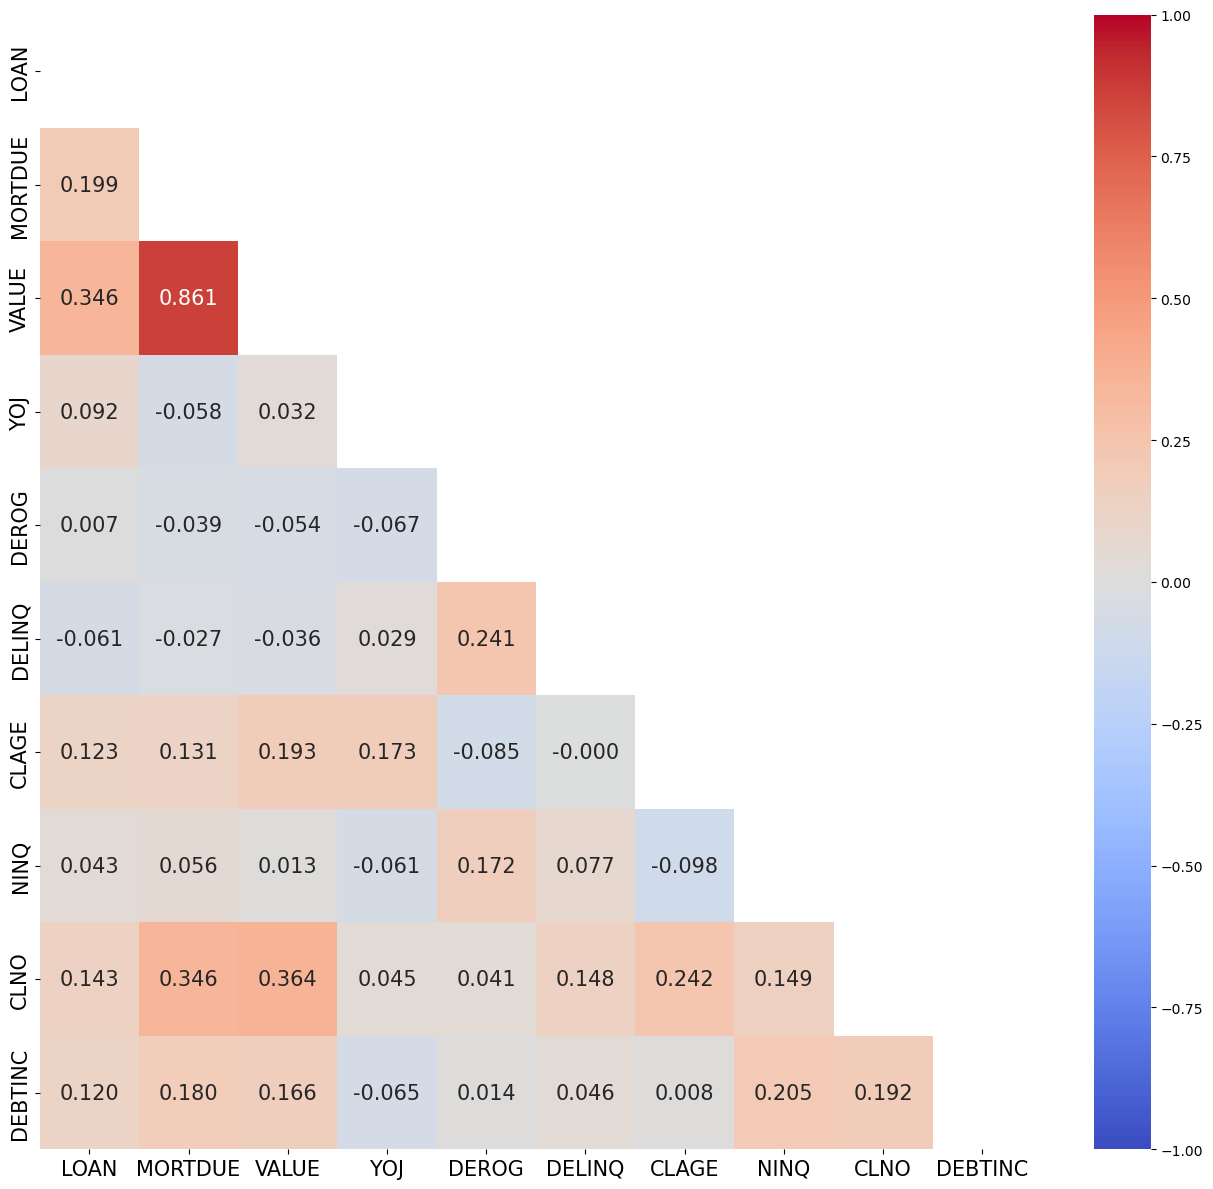

In [226]:
spearman_corr_matrix_plot(data, cont_vars)

**Association between continuous features and target variable**
- I use a point biserial correlation coefficient which measures strength and direction of the relationship between the continuous feature and binary variable.
$$r_X = \frac{\mu \left(X \;\middle|\; Y = 1 \right) - \mu_X}{\sigma_X} \sqrt{\frac{\Pr \left(Y = 1 \right)}{1 - \Pr \left(Y = 1\right)}}$$

In [112]:
def pointbiserial_corr_plot(df: pd.DataFrame, cont_vars: list,
                            target: str = "BAD", export: bool = True):

    coef_name = "Point Biserial coefficient"

    pointbis_corrs_df = pd.DataFrame(columns = [coef_name], index = cont_vars)

    for cont in cont_vars:

        filtered_df = df[df[cont].notna()]
        pointbis_corr = pointbiserialr(filtered_df[target], filtered_df[cont])[0]
        pointbis_corrs_df.loc[cont, coef_name] = pointbis_corr

    pointbis_corrs_df = pointbis_corrs_df.astype("float64")

    plt.figure(figsize = (3, 5))
    sns.heatmap(pointbis_corrs_df, vmin = -1, vmax = 1, annot = True, cmap  = "coolwarm", fmt = ".3f")
    plt.title("Point Biserial Correlation between \n the Continuous Features and Default", size = 13, fontweight = "bold")
    plt.tight_layout()
 
    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/Point_Biserial_Correlation_Continuous_Features_Default.jpg", dpi = 300)
    plt.show()

As can be seen, DEROG and DELINQ are quite positively associated with default status. Even though that other continous features don't have a strong association with default status, we can't rely on such measure, since it only captures an univariate relationship. Those features can be significant in a multivariate dimension.

In [113]:
def point_biserial_corr(data, num_features, target = 'BAD', significance_level = 0.01):
    
    #priting options
    no_dashes = 100
    for col in num_features:
        print(f"{no_dashes*'-'}")
        print(f'Point Biseral Correlation between the {col.capitalize()} and {target.capitalize()}')
        print(f"{no_dashes*'-'}")
        
        temp_df = data[data[col].notna()].copy()
        coef, p_value = pointbiserialr(temp_df[target], temp_df[col])

        y_1 = temp_df.loc[temp_df[target] == 1, col].mean()
        y_0 = temp_df.loc[temp_df[target] == 0, col].mean()
        n_1 = temp_df.loc[temp_df[target] == 1, target].shape[0]
        n_0 =  temp_df.loc[temp_df[target] == 0, target].shape[0]
        n = temp_df.shape[0]
        s = np.std(temp_df[col])



        print(f'Point Biseral Correlation Coefficient: {coef}')
        print('Point Biseral Correlation Coefficient:', ((y_1 - y_0)*np.sqrt((n_1*n_0)/(n*(n-1))))/s)
        print(f'p-value: {p_value}')
        
        
        result_significance = '' if float(p_value) <= significance_level else 'not '
        result_strength = 'weak' if float(coef) <= 0.2 else 'moderate' if float(coef) <= 0.5 else 'strong'
        significance_level_print = int(significance_level*100) if (significance_level*100).is_integer() else significance_level*100
        significance_starts =  '***' if p_value <= 0.01 else '**' if p_value <= 0.05 else '*' if p_value <= 0.1 else ' '
        print('significance:', significance_starts)
        print(f"RESULT: The association is {result_strength} and is {result_significance}statistically significant on the {significance_level_print}% significance level.")
        print(f"{no_dashes*'-'}", '\n')
    

In [114]:
point_biserial_corr(data, cont_vars)

----------------------------------------------------------------------------------------------------
Point Biseral Correlation between the Loan and Bad
----------------------------------------------------------------------------------------------------
Point Biseral Correlation Coefficient: -0.0750989203107898
Point Biseral Correlation Coefficient: -0.07510522134870486
p-value: 6.448273297843172e-09
significance: ***
RESULT: The association is weak and is statistically significant on the 1% significance level.
---------------------------------------------------------------------------------------------------- 

----------------------------------------------------------------------------------------------------
Point Biseral Correlation between the Mortdue and Bad
----------------------------------------------------------------------------------------------------
Point Biseral Correlation Coefficient: -0.04821918143516381
Point Biseral Correlation Coefficient: -0.04822361232710449
p-val

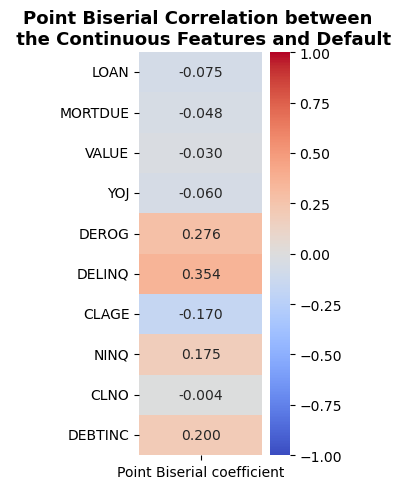

In [115]:
pointbiserial_corr_plot(data, cont_vars)

**Association between categorical features and target variable**

We can use Cramer's V which is commonly used for measuring association between multi-categorical vs binary variables, or multi-categorical vs multicategorical variables.
$$V_{cr} = \sqrt{\frac{\chi^2}{N(k-1)}}$$

In [116]:
def cat_feats_association_target(df: pd.DataFrame, cat_vars: list, target: str = "BAD", significance_level: float = 0.01):

    dashes = 100 * "-"
    pairs = list(combinations(cat_vars + [target], 2))
    print(pairs)
    pairs =  [sorted(pair) for pair in pairs]
    print(pairs)
    pairs = sorted(pairs)
    print(pairs)
    for pair in pairs:
        cross_tab = pd.crosstab(data[pair[0]], data[pair[1]])
        chi2, p_value, *_ = chi2_contingency(cross_tab, correction=False)
        N = cross_tab.sum().sum()
        k = min(cross_tab.shape)
        cr_v = np.sqrt((chi2/N) / (k-1))


        print(dashes)
        print(f"{'DEFAULT' if pair[0] == 'BAD' else pair[0]} vs {'DEFAULT' if pair[1] == 'BAD' else pair[1]}:")
        print(dashes)

        result_significance = '' if p_value <= significance_level else 'not '
        result_strength = 'weak' if cr_v <= 0.2 else 'moderate' if cr_v <= 0.6 else 'strong'
        significance_level_print = int(significance_level*100) if (significance_level*100).is_integer() else significance_level*100
        significance_starts =  '***' if p_value <= 0.01 else '**' if p_value <= 0.05 else '*' if p_value <= 0.1 else ' '
        print(f"Cramer's V: {round(cr_v, 3)}")
        print(f"Chi squared statistic: {round(chi2, 3)}")
        print(f"p-value: {p_value}")
        print(f"significance: {significance_starts}")
        
        
        print(dashes)
        print(f"RESULT: The association is {result_strength} and is {result_significance}statistically significant on the {significance_level_print}% significance level.")
        print(dashes, '\n')
    

As can be seen, all the associations are quire weak, but statistically significant.

In [117]:
cat_feats_association_target(data, cat_vars)

[('REASON', 'JOB'), ('REASON', 'BAD'), ('JOB', 'BAD')]
[['JOB', 'REASON'], ['BAD', 'REASON'], ['BAD', 'JOB']]
[['BAD', 'JOB'], ['BAD', 'REASON'], ['JOB', 'REASON']]
----------------------------------------------------------------------------------------------------
DEFAULT vs JOB:
----------------------------------------------------------------------------------------------------
Cramer's V: 0.12
Chi squared statistic: 81.932
p-value: 3.3066762328584986e-16
significance: ***
----------------------------------------------------------------------------------------------------
RESULT: The association is weak and is statistically significant on the 1% significance level.
---------------------------------------------------------------------------------------------------- 

----------------------------------------------------------------------------------------------------
DEFAULT vs REASON:
----------------------------------------------------------------------------------------------------


**Association between NA's of features**

Phi coefficient for measuring association between the two binary variables.
$$\phi = \sqrt{\frac{\chi^2}{n}}$$

In [118]:
def phi_correlation(var1, var2):

    cross_tab = pd.crosstab(var1, var2)

    chi2, p_value, *_ = chi2_contingency(cross_tab)
    n = cross_tab.sum().sum() 

    phi = np.sqrt(chi2/n)
    
    return phi

In [119]:
def phi_correlation_na_default(df: pd.DataFrame, target: str = "BAD", significance_level: float = 0.01):

    dashes = 100 * "-"

    df_copy = df.copy()

    for col in [i for i in df_copy.columns if i != target]:
        na_indicator = [1 if pd.isnull(i) else 0 for i in df_copy[col]]
        cross_tab = pd.crosstab(df_copy[target], na_indicator)
        chi2, p_value, *_ = chi2_contingency(cross_tab)
        n = cross_tab.sum().sum() 

        phi = np.sqrt(chi2/n)

        print(dashes)
        print(f"{'DEFAULT' if target == 'BAD' else target} vs {col.upper()}:")
        print(dashes)


        result_significance = '' if p_value <= significance_level else 'not '
        result_strength = 'weak' if phi <= 0.2 else 'moderate' if phi <= 0.6 else 'strong'
        significance_level_print = int(significance_level*100) if (significance_level*100).is_integer() else significance_level*100
        significance_starts =  '***' if p_value <= 0.01 else '**' if p_value <= 0.05 else '*' if p_value <= 0.1 else ' '
        print(f"Phi: {round(phi, 3)}")
        print(f"Chi squared statistic: {round(chi2, 3)}")
        print(f"p-value: {p_value}")
        print(f'significance: {significance_starts}')
        
        
        print(dashes)
        print(f"RESULT: The association is {result_strength} and is {result_significance}statistically significant on the {significance_level_print}% significance level.")
        print(dashes, '\n')

phi_correlation_na_default(data)

----------------------------------------------------------------------------------------------------
DEFAULT vs LOAN:
----------------------------------------------------------------------------------------------------
Phi: 0.0
Chi squared statistic: 0.0
p-value: 1.0
significance:  
----------------------------------------------------------------------------------------------------
RESULT: The association is weak and is not statistically significant on the 1% significance level.
---------------------------------------------------------------------------------------------------- 

----------------------------------------------------------------------------------------------------
DEFAULT vs MORTDUE:
----------------------------------------------------------------------------------------------------
Phi: 0.003
Chi squared statistic: 0.062
p-value: 0.8036566387990592
significance:  
----------------------------------------------------------------------------------------------------
RESULT

In [120]:
def phi_corr_feat_na_plot(df: pd.DataFrame, target: str = "BAD", export: bool = True):

    df_ = df.drop(target, axis = 1).copy()
    
    phi_na_df = pd.DataFrame(columns = df_.columns, index = df_.columns)

    for var1 in df_.columns:
        temp = df_.drop(var1, axis = 1)
        bool_var_nas_1 = [1 if pd.isnull(i) else 0 for i in df_[var1]]

        for var2 in temp.columns:
            bool_var_nas_2 = [1 if pd.isnull(i) else 0 for i in df_[var2]]
            phi = phi_correlation(bool_var_nas_1, bool_var_nas_2)
            phi_na_df.loc[var1, var2] = phi

    phi_na_df = phi_na_df.astype("float64")
    phi_na_df.index = [f"{col}_IS_NA" for col in df_.columns]
    phi_na_df.columns = [f"{col}_IS_NA" for col in df_.columns]

    plt.figure(figsize = (15, 15))
    sns.heatmap(phi_na_df, vmin = -1, vmax = 1, annot = True, fmt = ".3f",
                mask = np.triu(np.ones_like(phi_na_df)), cmap  = "coolwarm")
    
    plt.title("Phi correlation between the NA's of Features", size = 13, fontweight=  "bold")
    
    plt.tight_layout()

    #Exporting the plots
    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/Phi_Correlation_NA_Features.jpg", dpi = 300)

    plt.show()

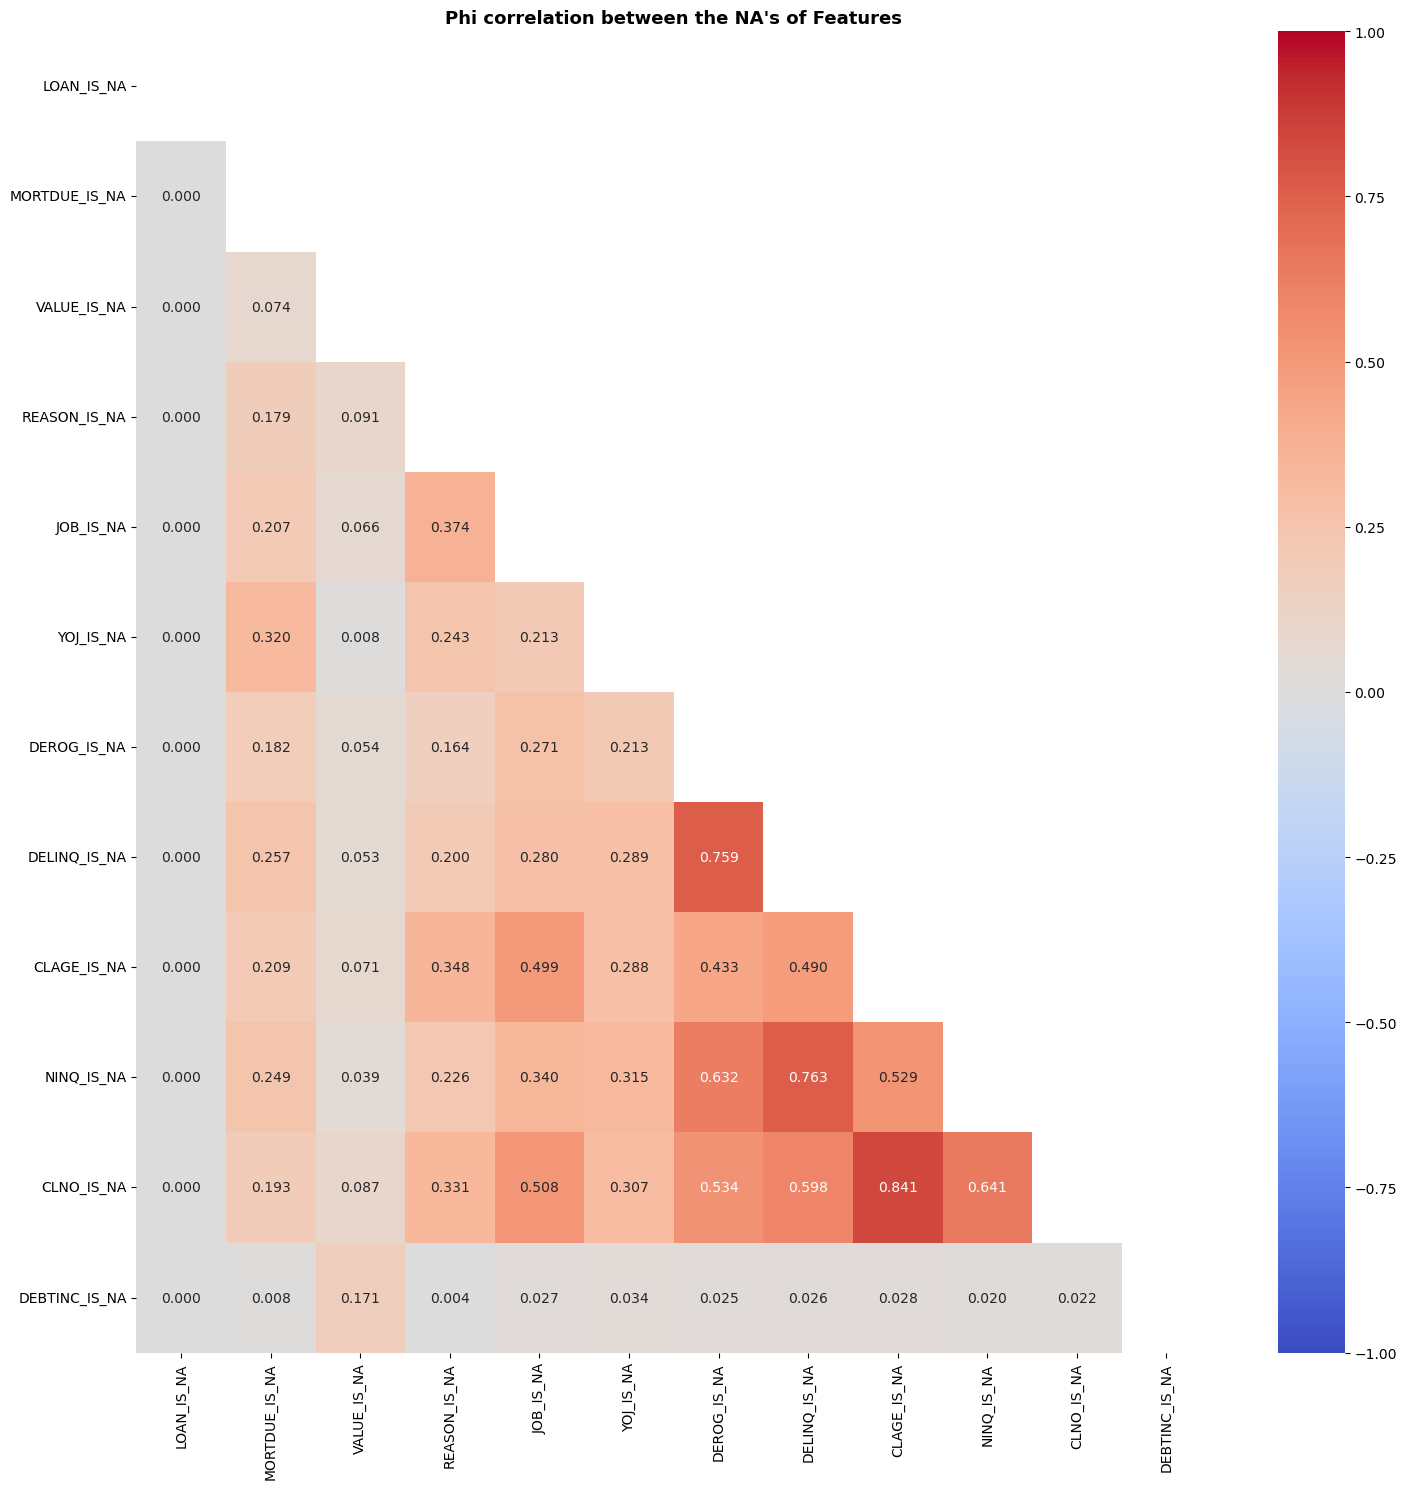

In [121]:
phi_corr_feat_na_plot(data)

**Association between NA's of features and target variable**

In [122]:
def phi_correlation_na_default_plot(df: pd.DataFrame, target: str = "BAD", export: bool = True):

    coef_name = "Phi correlation"

    features_names = [col for col in df.columns if col != target]

    phi_na_default_df = pd.DataFrame(columns = [coef_name], index = features_names)

    for var in features_names:
        bool_var_nas = [1 if pd.isnull(i) == True else 0 for i in df[var]]

        try:
            phi_coeff = phi_correlation(df[target], bool_var_nas)

        except IndexError:
            phi_coeff = 0
            
        phi_na_default_df.loc[var, coef_name] = phi_coeff

    phi_na_default_df = phi_na_default_df.astype("float64")
    phi_na_default_df.index = [f"{col}_IS_NA" for col in features_names]

    plt.figure(figsize = (2, 5))

    sns.heatmap(phi_na_default_df, vmin = -1, vmax = 1, annot = True,
                fmt = ".3f", cmap  = "coolwarm", cbar_kws={"shrink": 0.90})
    
    plt.title("Phi Correlation between \n the NA's of Features and Default",
              size = 13, fontweight = "bold")

    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/Phi_Correlation_NA_Default.jpg", dpi = 300)

    plt.show()

We can observe that if current property value (VALUE) or Debt-to-Income ratio (DEBTINC) missing, it is also associated with default,

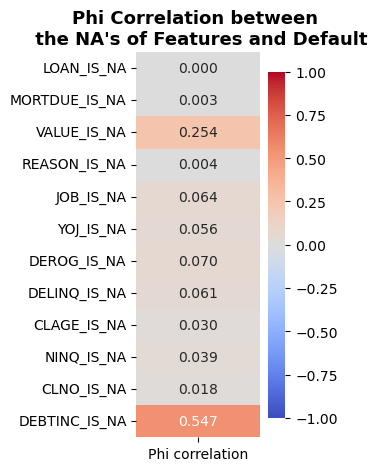

In [123]:
phi_correlation_na_default_plot(data)

## **Data Processing**

**Slit of data**
- Stratification to ensure the same target distribution across the samples.
- Split into training set (for training the models, hyperparameter tuning and feature selection), validation set (for the model selection) and test set (for evaluation of the final model).

**ADASYN Oversampling**
- Since the target variable distribution is heavily imbalanced, the model would be biased towards majority class (non-default)
- Therefore we perform ADASYN Oversampling which synthetically replicates minority instances using KNN.
- We perform oversampling on training set only in order to avoid data leakage.

In [124]:
def data_split(df: pd.DataFrame, test_size: float,
               validation_size: float, seed: int,
               oversampling: str = 'None',
               target: str = "BAD") -> tuple[pd.DataFrame, pd.Series,
                                             pd.DataFrame, pd.Series,
                                             pd.DataFrame, pd.Series]:
    
    #Separating the target variable (Y) and the features (X)
    Y = df[target]
    X = df.drop(target, axis = 1)

    #Stratified split into training set, validation set and test set
    X_temp, X_test, y_temp, y_test = train_test_split(X, Y, stratify = Y, test_size = test_size, random_state = seed)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, stratify = y_temp, test_size = validation_size, random_state = seed)


    #ADASYN Oversampling
    if oversampling == 'ADASYN':

        #ADASYN initialization
        adasyn = ADASYN(random_state = seed, n_jobs = -1)

        #Temporary imputing of missing values (separately for categorical and continuous features)
            #ADASYN cannot work with NA's, thus we replace them with arbitrary values.
        X_train_imputed = pd.concat((X_train[cat_vars].copy().fillna("NAN"),
                                     X_train[cont_vars].copy().fillna(99999999999999)),
                                    axis = 1)[X_train.columns].copy()

        #Dummy encoding of categorical features
            #ADASYN cannot work with categorical features, thus we need to encode them.
        for cat in cat_vars:
            X_cat_dummies =  pd.get_dummies(X_train_imputed[[cat]])
            X_train_imputed = X_train_imputed.drop(cat, axis = 1)
            X_train_imputed = pd.concat((X_train_imputed, X_cat_dummies), axis = 1)

        #Oversampling on the training set.
        X_train_final, y_train_final = adasyn.fit_resample(X_train_imputed, pd.DataFrame(y_train))

        #Converting dummies back into the original categorical features.
        for cat in cat_vars:
            X_train_final[cat] = X_train_final.loc[:, [col for col in X_train_final.columns if cat in col]].idxmax(axis = 1).str.replace(f"{cat}_", "")
            X_train_final = X_train_final.drop([col for col in X_train_final.columns if f"{cat}_" in col], axis = 1)

        #Replacing the NA's strings back to NA's with respect to the categorical features.
        X_train_final = X_train_final.replace({"NAN": np.nan})

        #Replacing back the missing values (99999999999999) with NA's in such case whether the value is exceeding the maximum value of given continuous feature before imputing.
        for cont in cont_vars:
            max_value = X_train[cont].max()
            X_train_final[cont] =  X_train_final[cont].apply(lambda x: np.nan if x > max_value else x)

        y_train_final = y_train_final[target]
            
        X_train_final = X_train_final.reindex(columns = X_train.columns)

        return X_train_final, y_train_final, X_valid, y_valid, X_test, y_test
    
    #No oversampling
    else:

        return X_train, y_train, X_valid, y_valid, X_test, y_test

In [125]:
X_train, y_train, X_valid, y_valid, X_test, y_test = data_split(data, test_size, validation_size, seed, oversampling = "ADASYN")

In [158]:
X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_ = data_split(data, test_size, validation_size, seed)

Some info about the split data

In [126]:
def print_data_info(**kwargs):
    
    for name, _set in kwargs.items():

        no_dashes = 50
        no_dashes_name_left = int((no_dashes - len(name) - 1)/2)*"-"
        no_dashes_name_right  = f"{(no_dashes - len(name) - len(no_dashes_name_left) - 2)*'-'}"

        data_info = f"{_set['features'].shape[0]} instances, {_set['features'].shape[1]} features"
        no_dashes_data_info_left = int((no_dashes - len(data_info) - 1)/2)*"-"
        no_dashes_data_info_right = f'{(no_dashes - len(data_info) - len(no_dashes_data_info_left) - 2)*"-"}'

        target_info = f"Default: {np.sum(_set['target']) / _set['target'].shape[0]*100:.2f}%  | Non-default: {np.sum(_set['target'] == 0)/ _set['target'].shape[0]*100:.2f}%"
        no_dashes_target_info_left = int((no_dashes - len(target_info) - 1)/2)*"-"
        no_dashes_target_info_right = f'{(no_dashes - len(target_info) - len(no_dashes_target_info_left) - 2)*"-"}'


        print(no_dashes*"-")
        print(f"{no_dashes_name_left} {name} {no_dashes_name_right}")
        print(f"{no_dashes_data_info_left} {data_info} {no_dashes_data_info_right}")
        print(f"{no_dashes_target_info_left} {target_info} {no_dashes_target_info_right}")
        print(no_dashes*"-", "\n")

In [127]:
print_data_info(Training = {'features': X_train, 'target': y_train},
                Validation = {'features': X_valid, 'target': y_valid},
                Test = {'features': X_test, 'target': y_test})

--------------------------------------------------
-------------------- Training --------------------
----------- 6437 instances, 12 features ----------
----- Default: 48.13%  | Non-default: 51.87% -----
-------------------------------------------------- 

--------------------------------------------------
------------------- Validation -------------------
----------- 895 instances, 12 features -----------
----- Default: 20.00%  | Non-default: 80.00% -----
-------------------------------------------------- 

--------------------------------------------------
---------------------- Test ----------------------
----------- 894 instances, 12 features -----------
----- Default: 19.91%  | Non-default: 80.09% -----
-------------------------------------------------- 



**Optimal binning and WoE encoding**
  - Binning and WoE encoding is commonly used in credit risk modelling.
  - Binning (discretization) can capture non-linearity in data (with respect to the target).
  - Binning can capture outliers (in the lowest/highest bins).
  - Binning creates a special bin for missing values only, thus no imputing or deletion is necessary (with such approach, we assume that missing value have some kind of significant information with respect to the target).
  - WoE is used as a transformation of categorical features having bins. It is more appropriate approach than dummy or ordinal encoding - because dummy can lead to the curse of dimensionality (when having too much bins) and ordinal encoding assumes uniform distances between the orders (which is not always the case in practice).
- Particularly, I use **BinningProcess** from **optbinning** library which optimally dicretizes both continous features into intervals and categorical features into subgroups of categories and then transforms the intervals and and subgroups (bins) using Weight-of-Evidence.
  - Let us assume feature $X$  and its particular bin $b$ and a target variable $Y$.
  - Thus WoE of bin $b$ of variable $X$ is calculated as a natural logarithm of a ratio of probability of occurence in bin $b$ conditional on target $Y$ being $1$, and probability of occurence in bin $b$ conditional on target $Y$ being $0$.
  - In other words, the numerator within a natural logarithm is a number of instances which belong to given bin $b$ and have not defaulted yet, divided by the number of all instances which have not defaulted across the whole dataset. The denominator within a natural logarithm is a number of instances which belong to given $b$ and have defaulted, divided by the number of all instances which have not defaulted across the whole dataset.

$$WoE_{X, b}= \ln \left(\frac{\Pr{\left(X = b\;\middle|\;Y = 0\right)}}{\Pr{\left(X = b\;\middle|\;Y = 1\right)}}\right)$$

As an example, let us assume a dataset of 5000 instances where 4000 have not defaulted and 1000 have defaulted. Further, let us assume some random feature called $F$ that has $k$ number of bins. Let us also assume that within bin $b_{i}$, there are 500 instances where 210 have not defaulted and 290 have defaulted, hence WoE would be calculated as.

$$WoE_{F, b_{i}}= \ln \left(\frac{290/4000}{210/1000}\right) \approx -1.06$$

- As can be seen in the function below, I fit the **BinningProcess** object on the training set only and then transform training, validation and test set (in order to avoid the data leakage).

In [128]:
def woe_binning(x_train_set: pd.DataFrame, y_train_labels: pd.Series,
                cat_vars: list, export: bool = True,
                **kwargs) -> tuple[dict, pd.DataFrame]:


    binning_path = "./models/feature_preprocessing"
    final_objects_path = "./models/objects_FINAL"

    #Initializing the binning process object.
    bn = BinningProcess(variable_names = list(x_train_set.columns), categorical_variables = cat_vars)

    #Fitting the binning on training set.
    bn.fit(x_train_set, y_train_labels)

    #DataFrame including binned categories' information.
    bins_woe = pd.DataFrame()

    for i in x_train_set.columns:
        
        var = bn.get_binned_variable(i).binning_table.build()
        var = var[(~var["Bin"].isin(["Special"])) & (~var.index.isin(["Totals"]))]
        var["Variable"] = i

        bins_woe = pd.concat((bins_woe, var))

    bins_woe = bins_woe.loc[:, ~bins_woe.columns.isin(["IV","JS"])]
        
    if export:
        for save_path in [binning_path, final_objects_path]:
            os.makedirs(save_path, exist_ok = True)
            bn.save(f"{save_path}/binning_woe_object.h5")
            bins_woe.to_csv(f"{save_path}/woe_bins.csv", index = False)

    #Transforming both training set and test set based on the fitted training binning.
    def woe_bin_transform(bn_fit, x_set):
        x_set_binned = bn_fit.transform(x_set, metric = "woe")
        x_set_binned.index = x_set.index
        
        return x_set_binned
    
    X_binned_sets = {"X_train_binned": woe_bin_transform(bn, x_train_set)}
    x_set_copy = X_binned_sets['X_train_binned'].copy()

    for col in x_set_copy.columns:
        na_woe = bins_woe.query('Variable == @col and Bin == "Missing"')["WoE"].values[0]
        x_set_copy.loc[x_train_set[col].isna(), col] = na_woe
    X_binned_sets["X_train_binned"] = x_set_copy

    for name, x_set in kwargs.items():
        X_binned_sets[f"{name}_binned"] = woe_bin_transform(bn, x_set)
        x_set_copy = X_binned_sets[f"{name}_binned"].copy()
        for col in x_set_copy.columns:
            na_woe = bins_woe.query('Variable == @col and Bin == "Missing"')["WoE"].values[0]
            x_set_copy.loc[x_set[col].isna(), col] = na_woe
        X_binned_sets[f"{name}_binned"] = x_set_copy

    return (X_binned_sets, bins_woe, bn)

In [129]:
X_binned_sets, woe_bins, binning_transformator = woe_binning(X_train, y_train, cat_vars, X_valid = X_valid, X_test = X_test)

In [130]:
X_train_binned, X_valid_binned, X_test_binned = (x_set for _, x_set in X_binned_sets.items())

In [159]:
X_binned_sets_, woe_bins_, binning_transformator_ = woe_binning(X_train_, y_train_, cat_vars,export = False, X_valid = X_valid_, X_test = X_test_)
X_train_binned_, X_valid_binned_, X_test_binned_ = (x_set for _, x_set in X_binned_sets_.items())

In [131]:
woe_bins

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,Variable
0,"(-inf, 5690.50)",394,0.061209,99,295,0.748731,-1.16677,LOAN
1,"[5690.50, 7995.50)",488,0.075812,195,293,0.600410,-0.482088,LOAN
2,"[7995.50, 9299.50)",368,0.057169,179,189,0.513587,-0.129276,LOAN
3,"[9299.50, 16398.50)",2246,0.348920,1133,1113,0.495548,-0.057105,LOAN
4,"[16398.50, 20083.00)",902,0.140127,491,411,0.455654,0.102936,LOAN
...,...,...,...,...,...,...,...,...
3,"[34.60, 37.95)",803,0.124748,603,200,0.249066,1.028685,DEBTINC
4,"[37.95, 40.88)",766,0.119000,571,195,0.254569,0.999475,DEBTINC
5,"[40.88, 43.25)",423,0.065714,267,156,0.368794,0.462478,DEBTINC
6,"[43.25, inf)",323,0.050179,47,276,0.854489,-1.845168,DEBTINC


In [132]:
X_train_binned

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,-0.057105,0.521772,0.134681,-0.138316,0.249918,-0.213525,0.541692,0.852118,1.486801,-0.439946,0.011239,1.113310
1,0.102936,-0.202234,-0.110446,0.256585,0.249918,0.375422,0.541692,0.852118,1.066870,0.815383,0.201737,1.513406
2,0.102936,-0.202234,0.127610,1.311380,1.976977,0.601972,0.778476,0.831397,0.107407,0.690553,0.160914,0.999475
3,-0.057105,-0.202234,-0.110446,0.256585,0.249918,-0.018066,0.541692,-1.039360,-0.520537,-1.022168,-0.073454,-1.830269
4,0.338376,0.108852,0.134681,-0.138316,1.654014,-0.001487,0.541692,0.852118,-0.519400,-1.022168,0.201737,1.113310
...,...,...,...,...,...,...,...,...,...,...,...,...
6432,-1.166770,-0.202234,-0.110446,0.256585,-1.516882,-0.018066,0.541692,-1.764848,-0.899771,-0.439946,-0.073454,-1.830269
6433,-0.057105,-0.018387,0.127610,0.256585,-1.516882,-0.980156,-2.109236,-1.039360,-0.562618,-0.354152,-0.073454,-1.830269
6434,-0.057105,-0.018387,0.134681,-0.138316,-1.516882,-0.018066,-1.465212,-1.764848,-0.562618,-1.022168,-0.073454,-1.830269
6435,0.338376,0.108852,0.134681,-0.138316,-1.516882,-0.980156,-2.827417,-1.764848,-0.899771,-1.022168,-0.163385,-1.830269


In [133]:
X_valid_binned

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3941,0.338376,-0.202234,-0.110446,-0.138316,0.249918,-0.018066,0.541692,0.852118,0.107407,0.815383,-0.229769,-1.830269
1212,-0.057105,-0.202234,-0.110446,0.256585,-1.516882,0.375422,0.541692,-1.039360,1.066870,0.815383,0.011239,1.028685
3440,0.102936,-0.275758,0.134681,-0.138316,0.249918,0.375422,0.541692,0.852118,0.410988,-0.439946,-0.163385,1.028685
3995,0.338376,-0.202234,0.127610,0.256585,0.249918,-0.001487,0.541692,0.852118,-0.519400,-0.354152,0.201737,-1.830269
3713,0.102936,0.521772,0.134681,-0.138316,0.249918,0.375422,0.778476,-1.764848,-0.519400,0.815383,-0.073454,-1.845168
...,...,...,...,...,...,...,...,...,...,...,...,...
721,-0.129276,-0.018387,-0.110446,-0.138316,0.249918,0.447522,0.541692,-1.764848,-0.562618,-0.439946,0.011239,1.028685
1487,-0.057105,-0.018387,-0.110446,-0.138316,-1.516882,-0.980156,0.778476,0.831397,-0.562618,0.690553,-0.073454,0.999475
978,-0.057105,-0.275758,-0.377195,-0.138316,1.654014,-0.001487,-1.465212,-1.039360,-0.179893,-0.439946,0.011239,-1.830269
2822,-0.057105,-0.018387,0.127610,-0.138316,0.934009,-0.001487,-1.465212,-1.039360,1.486801,-1.022168,-0.163385,-1.830269


In [134]:
X_test_binned

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
2229,-0.057105,-0.018387,0.127610,-0.138316,1.654014,-0.001487,-2.109236,-1.764848,0.364117,-0.500582,-0.163385,1.028685
5743,0.452521,-0.275758,-0.110446,-0.138316,0.249918,0.375422,0.541692,0.852118,0.410988,0.815383,-0.163385,0.999475
4281,0.338376,0.521772,0.134681,-0.138316,0.934009,0.375422,0.541692,0.852118,0.364117,0.815383,-0.163385,0.999475
4734,0.338376,0.521772,0.134681,-0.138316,-1.516882,0.375422,0.541692,0.852118,0.410988,0.815383,0.201737,-1.830269
283,-0.482088,-0.275758,-0.377195,-0.138316,0.249918,1.270098,-1.465212,0.852118,-0.519400,-1.022168,-0.229769,1.513406
...,...,...,...,...,...,...,...,...,...,...,...,...
2238,-0.057105,-0.018387,0.127610,0.256585,0.249918,0.601972,0.541692,0.852118,1.486801,0.815383,-0.073454,1.513406
1908,-0.057105,-0.018387,0.127610,1.311380,0.934009,-0.001487,0.541692,0.852118,-0.562618,0.815383,0.201737,1.028685
1524,-0.057105,0.108852,0.134681,-0.138316,-1.516882,-0.980156,0.541692,0.852118,0.410988,-0.354152,-0.163385,-1.830269
4935,0.338376,0.108852,0.467630,1.311380,0.249918,1.270098,0.541692,-2.849815,-0.179893,-0.500582,-0.163385,-1.830269


Export of partially preprocessed data

In [135]:
def prep_data_export(features: tuple, labels: tuple,
                     ind_sets: tuple = ("Training", "Validation", "Test"),
                     csv_name:str = '') -> pd.DataFrame:

    df_list = []
    
    #Join each pair of features and labels data, assign to it a set indicator,
        # append to the list and then,
        #  transform that list into a data frame (and export it).
    for feat, lab, ind in zip(features, labels, ind_sets):
        
        temp = pd.concat((lab, feat), axis = 1)
        temp["set"] = ind
        df_list.append(temp)
    
    dfs = [df for df in df_list]

    final_df = pd.concat(dfs, axis = 0).sort_index()

    if len(csv_name) != 0:
        os.makedirs("./data/", exist_ok = True)
        final_df.to_csv(f"./data/{csv_name}.csv", index = False)
    
    return final_df

In [136]:
interim = prep_data_export((X_train_binned, X_valid_binned, X_test_binned),
                            (y_train, y_valid, y_test),
                            ("Training", "Validation", "Test"),
                            csv_name = "interim_data")

In [137]:
interim

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,set
0,0,-0.057105,0.521772,0.134681,-0.138316,0.249918,-0.213525,0.541692,0.852118,1.486801,-0.439946,0.011239,1.113310,Training
1,0,0.102936,-0.202234,-0.110446,0.256585,0.249918,0.375422,0.541692,0.852118,1.066870,0.815383,0.201737,1.513406,Training
2,0,0.102936,-0.202234,0.127610,1.311380,1.976977,0.601972,0.778476,0.831397,0.107407,0.690553,0.160914,0.999475,Training
3,1,-0.057105,-0.202234,-0.110446,0.256585,0.249918,-0.018066,0.541692,-1.039360,-0.520537,-1.022168,-0.073454,-1.830269,Training
4,1,0.338376,0.108852,0.134681,-0.138316,1.654014,-0.001487,0.541692,0.852118,-0.519400,-1.022168,0.201737,1.113310,Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6432,1,-1.166770,-0.202234,-0.110446,0.256585,-1.516882,-0.018066,0.541692,-1.764848,-0.899771,-0.439946,-0.073454,-1.830269,Training
6433,1,-0.057105,-0.018387,0.127610,0.256585,-1.516882,-0.980156,-2.109236,-1.039360,-0.562618,-0.354152,-0.073454,-1.830269,Training
6434,1,-0.057105,-0.018387,0.134681,-0.138316,-1.516882,-0.018066,-1.465212,-1.764848,-0.562618,-1.022168,-0.073454,-1.830269,Training
6435,1,0.338376,0.108852,0.134681,-0.138316,-1.516882,-0.980156,-2.827417,-1.764848,-0.899771,-1.022168,-0.163385,-1.830269,Training


**Distribution of WoE coefficients per feature**

- Assume that:

$$z = \left(\frac{\Pr{\left(X = x\;\middle|\;Y = 0\right)}}{\Pr{\left(X = x\;\middle|\;Y = 1\right)}}\right)$$
- Thus:
  - negative values indicates larger distribution of defaulters in given bin ($z > 1$, hence $\ln(z) > 0$)
  - positive values indicates larger distribution of non-defaulters in given bin ($z < 1$, hence $\ln(z) < 0$)

In [140]:
woe_bins

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,Variable
0,"(-inf, 5690.50)",394,0.061209,99,295,0.748731,-1.16677,LOAN
1,"[5690.50, 7995.50)",488,0.075812,195,293,0.600410,-0.482088,LOAN
2,"[7995.50, 9299.50)",368,0.057169,179,189,0.513587,-0.129276,LOAN
3,"[9299.50, 16398.50)",2246,0.348920,1133,1113,0.495548,-0.057105,LOAN
4,"[16398.50, 20083.00)",902,0.140127,491,411,0.455654,0.102936,LOAN
...,...,...,...,...,...,...,...,...
3,"[34.60, 37.95)",803,0.124748,603,200,0.249066,1.028685,DEBTINC
4,"[37.95, 40.88)",766,0.119000,571,195,0.254569,0.999475,DEBTINC
5,"[40.88, 43.25)",423,0.065714,267,156,0.368794,0.462478,DEBTINC
6,"[43.25, inf)",323,0.050179,47,276,0.854489,-1.845168,DEBTINC


In [146]:
b

array(['HomeImp'], dtype=object)

In [155]:
temp = woe_bins[woe_bins['Variable'].isin(['REASON','JOB'])]
d = {}
for cat in ['REASON','JOB']:
    temp_ = temp[temp['Variable'] == cat]
    temp_d = {}
    for b,w in zip(temp_['Bin'], temp_['WoE']):
        temp_d[round(w,5)] = str(b)
    d[cat] = temp_d
d

{'REASON': {0.25658: "['HomeImp']",
  -0.13832: "['DebtCon']",
  1.31138: 'Missing'},
 'JOB': {1.65401: "['Office']",
  0.93401: "['ProfExe']",
  0.24992: "['Self' 'Sales' 'Other']",
  -1.51688: "['Mgr']",
  1.97698: 'Missing'}}

In [156]:
x_  = X_train_binned.copy()
x_['REASON'] = x_['REASON'].round(5).map(d['REASON'])
x_['JOB'] = x_['JOB'].round(5).map(d['JOB'])
x_

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,-0.057105,0.521772,0.134681,['DebtCon'],['Self' 'Sales' 'Other'],-0.213525,0.541692,0.852118,1.486801,-0.439946,0.011239,1.113310
1,0.102936,-0.202234,-0.110446,['HomeImp'],['Self' 'Sales' 'Other'],0.375422,0.541692,0.852118,1.066870,0.815383,0.201737,1.513406
2,0.102936,-0.202234,0.127610,Missing,Missing,0.601972,0.778476,0.831397,0.107407,0.690553,0.160914,0.999475
3,-0.057105,-0.202234,-0.110446,['HomeImp'],['Self' 'Sales' 'Other'],-0.018066,0.541692,-1.039360,-0.520537,-1.022168,-0.073454,-1.830269
4,0.338376,0.108852,0.134681,['DebtCon'],['Office'],-0.001487,0.541692,0.852118,-0.519400,-1.022168,0.201737,1.113310
...,...,...,...,...,...,...,...,...,...,...,...,...
6432,-1.166770,-0.202234,-0.110446,['HomeImp'],['Mgr'],-0.018066,0.541692,-1.764848,-0.899771,-0.439946,-0.073454,-1.830269
6433,-0.057105,-0.018387,0.127610,['HomeImp'],['Mgr'],-0.980156,-2.109236,-1.039360,-0.562618,-0.354152,-0.073454,-1.830269
6434,-0.057105,-0.018387,0.134681,['DebtCon'],['Mgr'],-0.018066,-1.465212,-1.764848,-0.562618,-1.022168,-0.073454,-1.830269
6435,0.338376,0.108852,0.134681,['DebtCon'],['Mgr'],-0.980156,-2.827417,-1.764848,-0.899771,-1.022168,-0.163385,-1.830269


In [178]:
data.JOB.value_counts(normalize=True, dropna=False)

Other      0.400671
ProfExe    0.214094
Office     0.159060
Mgr        0.128691
NaN        0.046812
Self       0.032383
Sales      0.018289
Name: JOB, dtype: float64

In [179]:
data.query('BAD == 1').JOB.value_counts(normalize=True, dropna=False)

Other      0.465938
ProfExe    0.178301
Mgr        0.150547
Office     0.105130
Self       0.048780
Sales      0.031960
NaN        0.019344
Name: JOB, dtype: float64

In [180]:
data.query('BAD == 0').JOB.value_counts(normalize=True, dropna=False)

Other      0.384406
ProfExe    0.223014
Office     0.172501
Mgr        0.123245
NaN        0.053658
Self       0.028296
Sales      0.014882
Name: JOB, dtype: float64

In [184]:
pd.concat((X_train,y_train),axis=1).JOB.value_counts(normalize=True, dropna=False)

Other      0.346901
Mgr        0.319248
ProfExe    0.158148
Office     0.107193
NaN        0.031381
Self       0.023769
Sales      0.013360
Name: JOB, dtype: float64

In [185]:
pd.concat((X_train,y_train),axis=1).query('BAD == 1').JOB.value_counts(normalize=True, dropna=False)

Mgr        0.536475
Other      0.304390
ProfExe    0.087799
Office     0.033570
Self       0.018722
Sales      0.011620
NaN        0.007424
Name: JOB, dtype: float64

In [186]:
pd.concat((X_train,y_train),axis=1).query('BAD == 0').JOB.value_counts(normalize=True, dropna=False)

Other      0.386343
ProfExe    0.223420
Office     0.175502
Mgr        0.117700
NaN        0.053609
Self       0.028452
Sales      0.014975
Name: JOB, dtype: float64

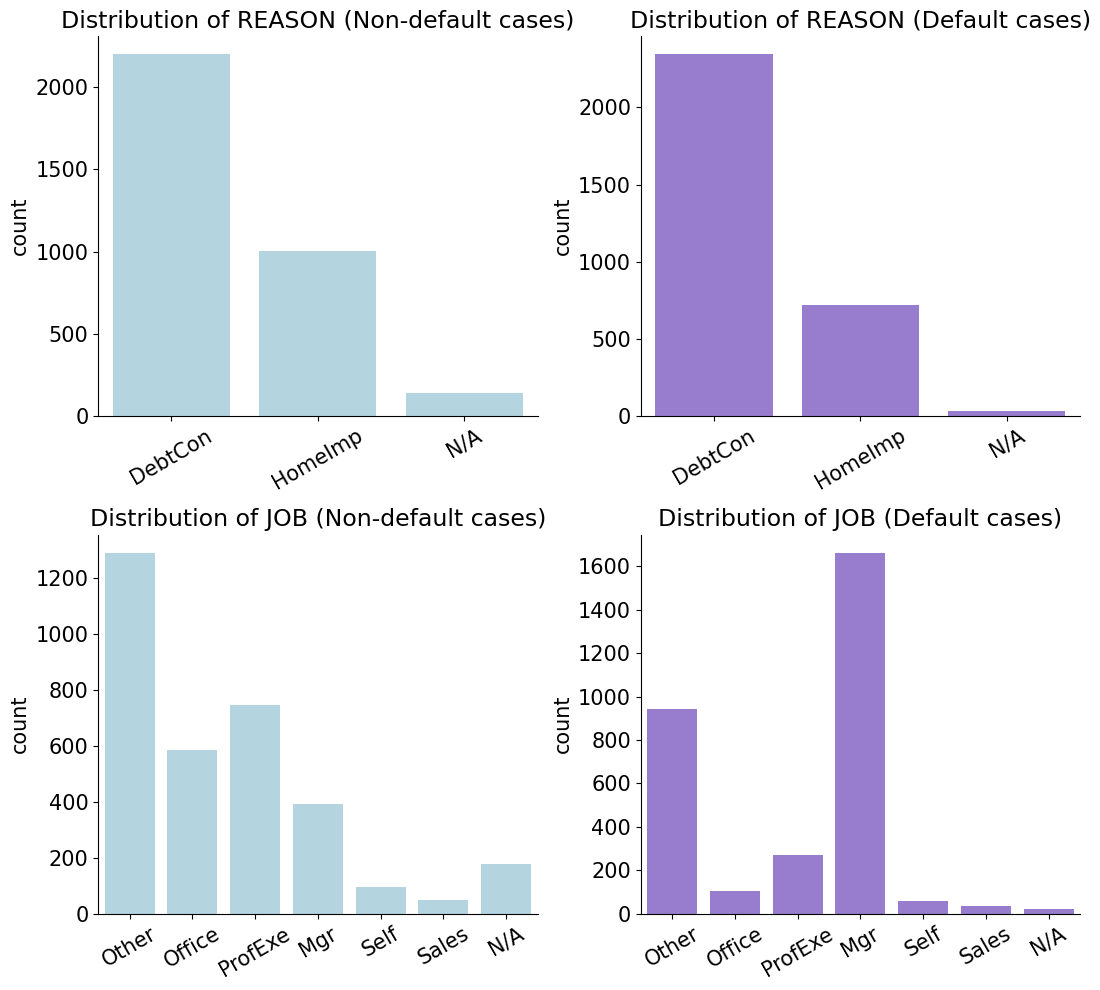

In [176]:
categorical_distribution_plot(pd.concat((X_train, y_train), axis = 1), cat_vars, export = False)

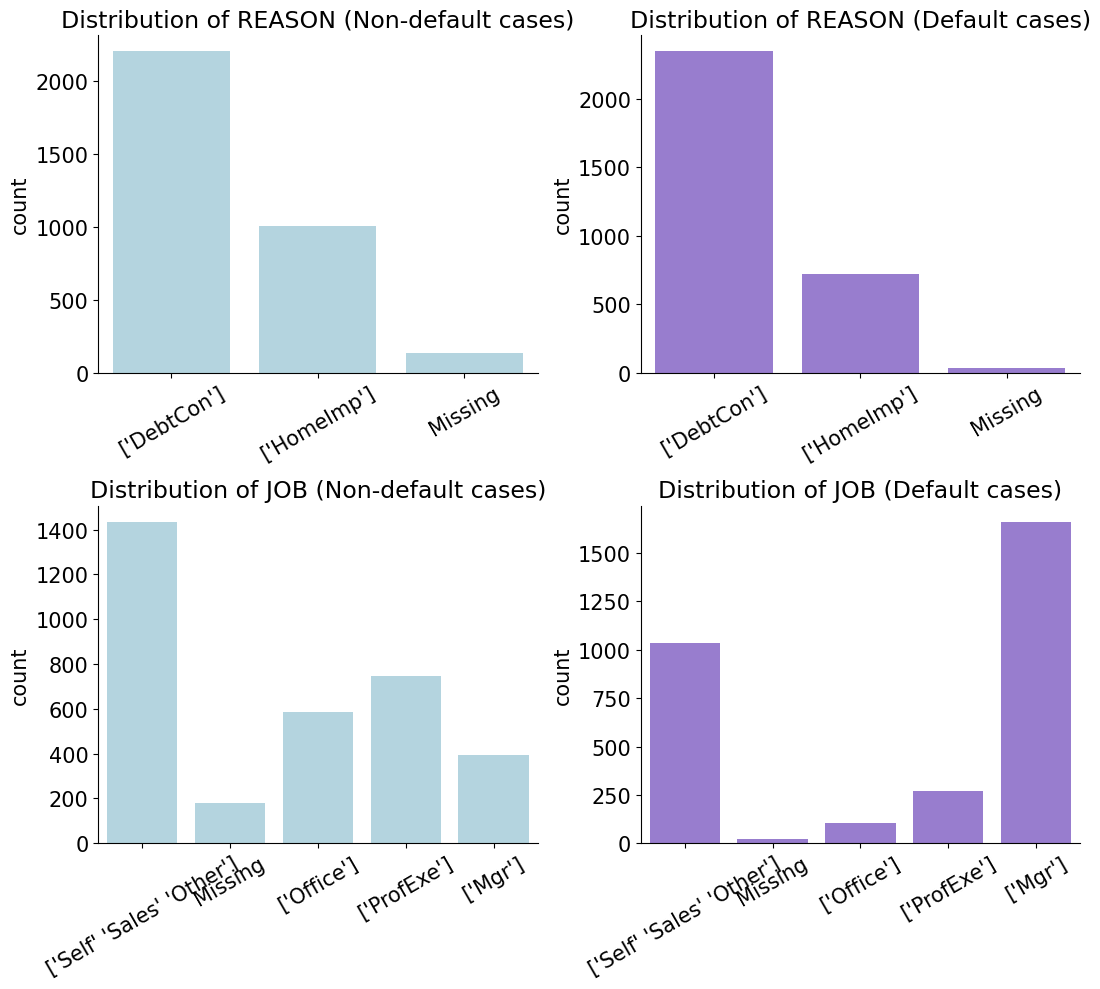

In [157]:
categorical_distribution_plot(pd.concat((x_, y_train), axis = 1), cat_vars, export = False)

In [161]:
def woe_bins_plot(bins_woe: pd.DataFrame, export: bool = True):

    fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 25))
    
    for i, ax in zip(bins_woe["Variable"].unique(), axs.ravel()):
    
        temp = bins_woe.loc[bins_woe["Variable"] == i]
        sns.barplot(x = temp.index, y = "WoE", data = temp, ax = ax, palette = "BuPu")
        ax.axhline(y = 0, color = "black", linewidth = 1)
        
        cat = False

        for j in temp["Bin"]:
            if isinstance(j, np.ndarray):
                cat = True
                break
        if cat == False:
            labels = list(temp["Bin"])
 
        elif cat == True:
            labels = [k if type(k) == type("Missing") else str(list(k)).replace("[", "").replace("]", "").replace("'","") for k in temp["Bin"]]
        
        ax.set_title(i, size = 13)
        ax.set_xticklabels(labels, rotation = 90, size = 11)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    

    fig.tight_layout()

    fig.suptitle("WoE coefficients' Distribution per Features", fontsize = 16, fontweight = "bold")
    fig.subplots_adjust(top=0.95)
    
    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/WoE_Distribution.jpg", dpi = 300)

    plt.show()

We can observe that the bins capture non-linear pattern with respect to the target.

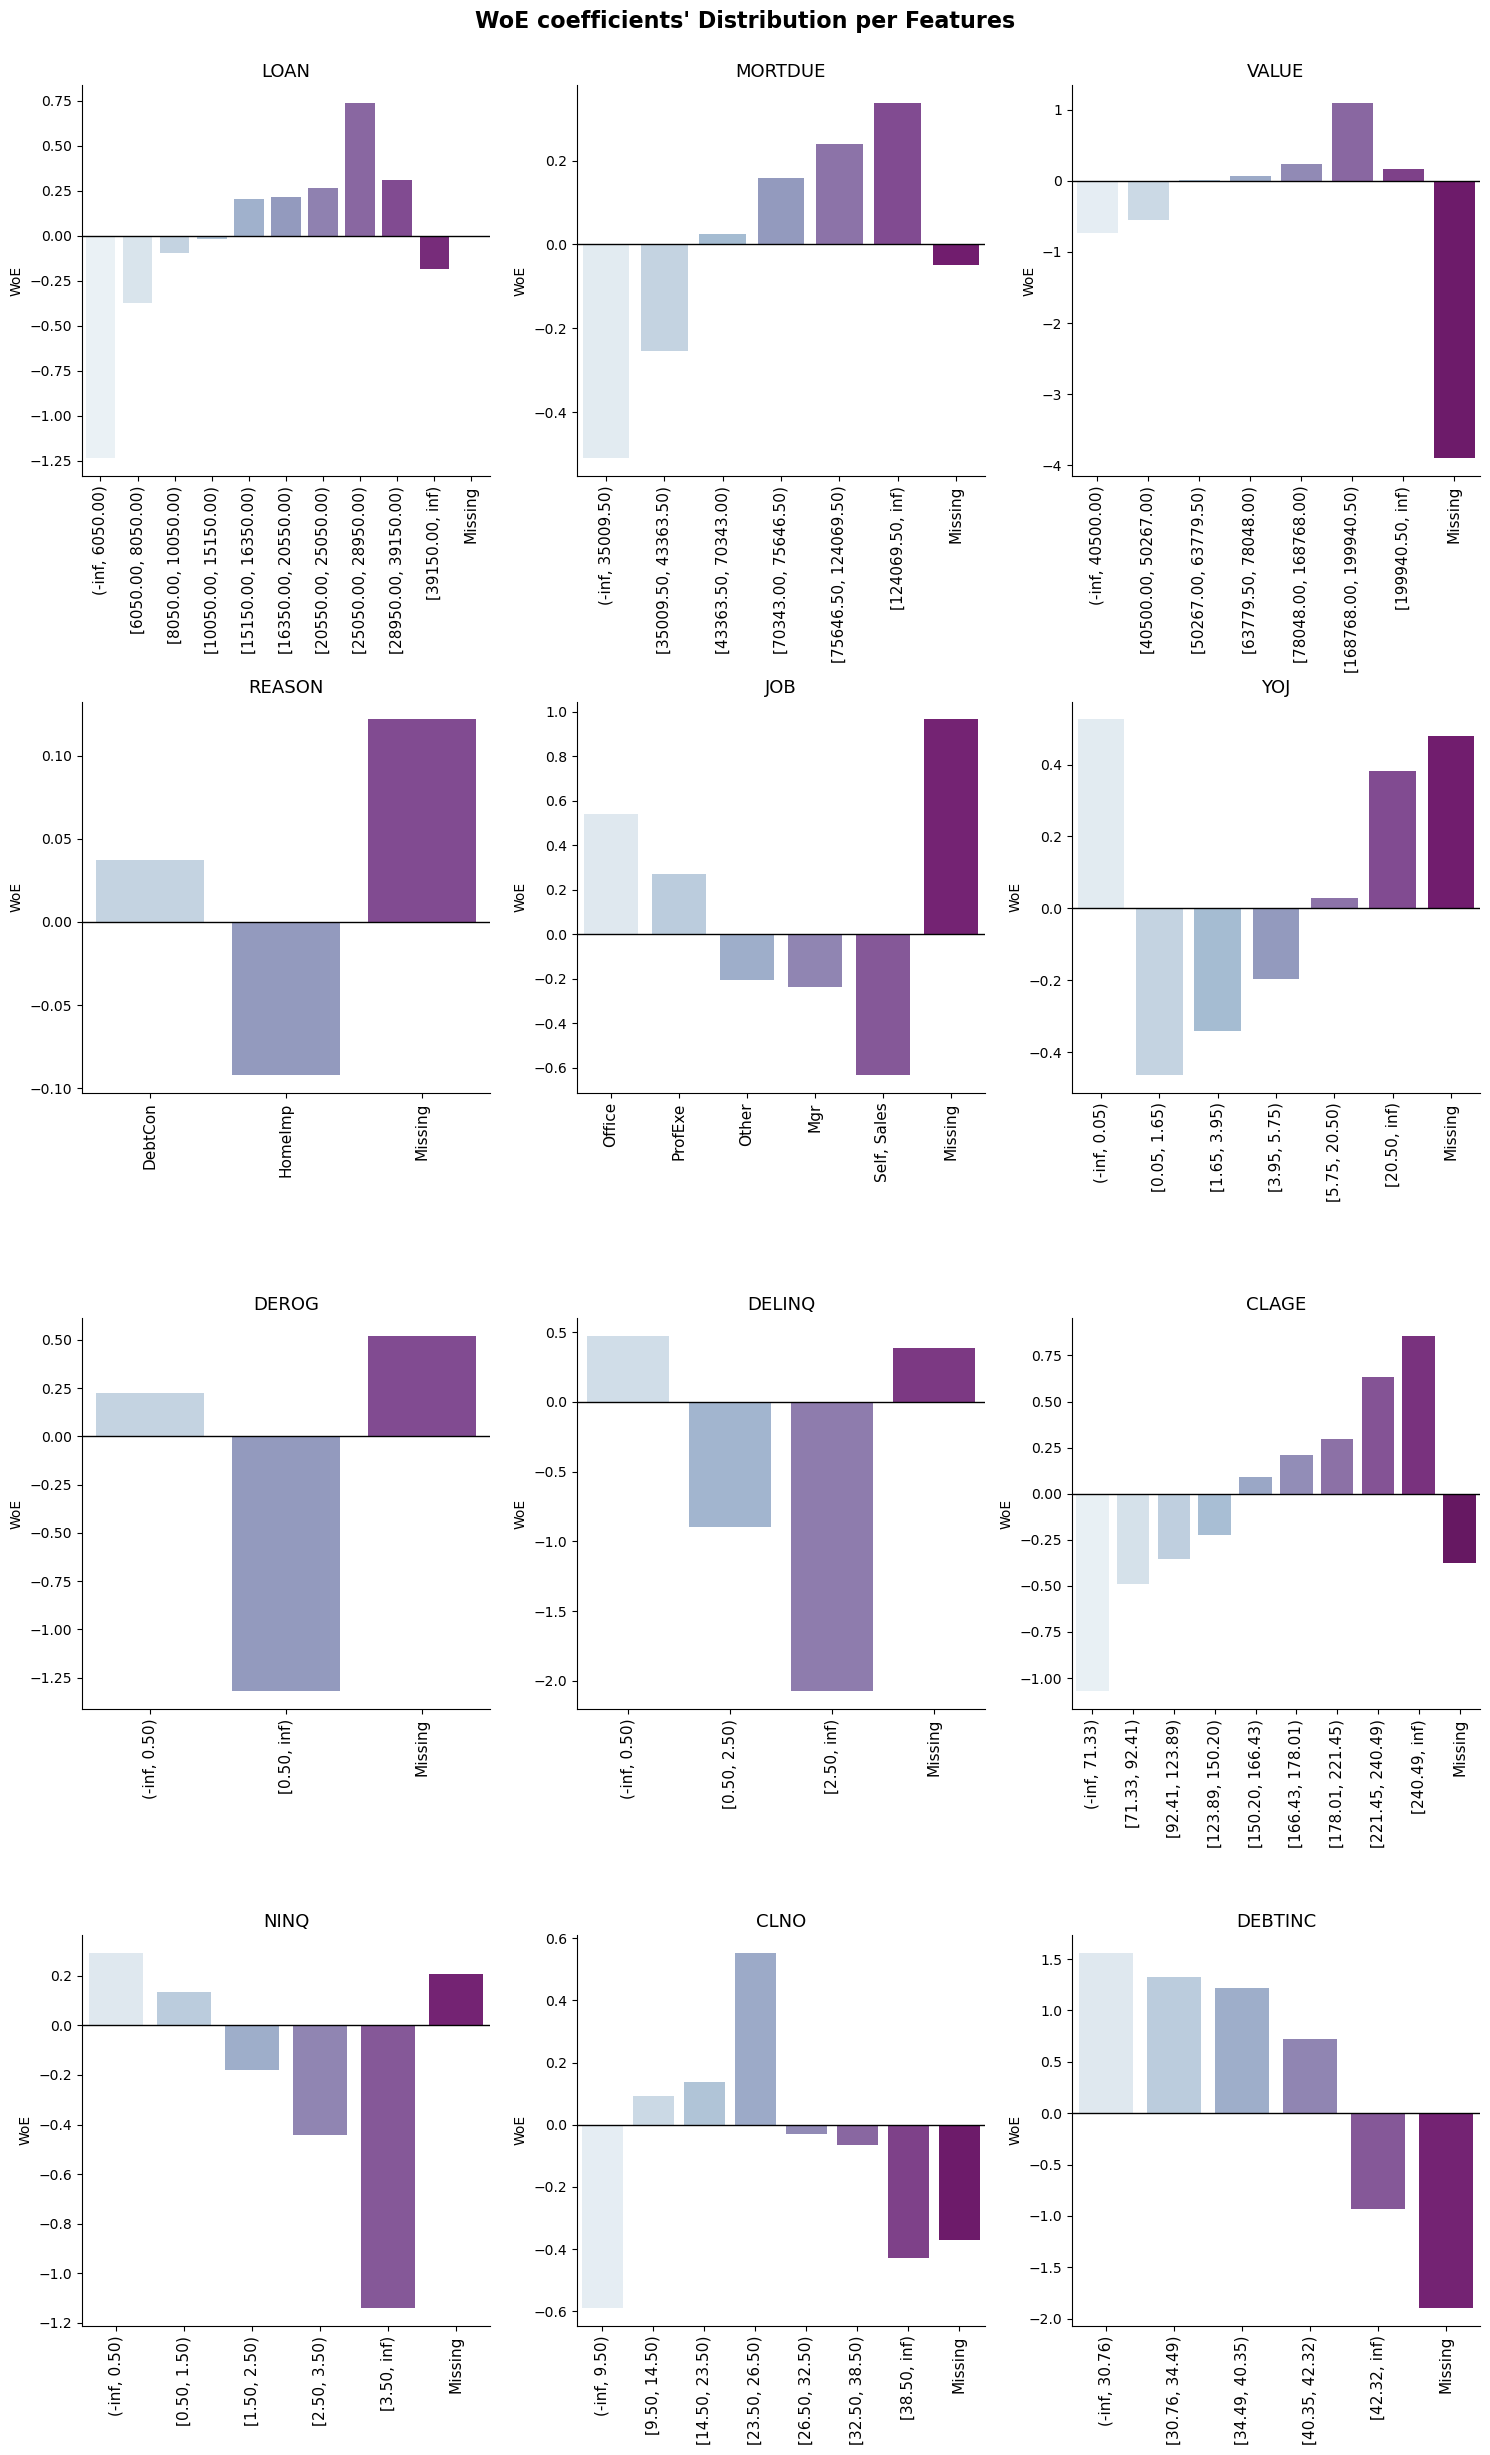

In [162]:
woe_bins_plot(woe_bins_, export = False)

In [189]:
cat = 'JOB'
temp_data = data.copy()
temp_data[cat] = temp_data[cat].fillna('N/A')

pd.crosstab(temp_data[cat], temp_data['BAD'], normalize = 'index')

BAD,0,1
JOB,,
Mgr,0.766623,0.233377
N/A,0.917563,0.082437
Office,0.868143,0.131857
Other,0.768007,0.231993
ProfExe,0.833856,0.166144
Sales,0.651376,0.348624
Self,0.699482,0.300518


In [194]:
temp_data['JOB'] = temp_data['JOB'].fillna('N/A')
temp_data['REASON'] = temp_data['REASON'].fillna('N/A')

In [196]:
temp_data['REASON'].value_counts(normalize=True, dropna=False)

DebtCon    0.659060
HomeImp    0.298658
N/A        0.042282
Name: REASON, dtype: float64

In [197]:
pd.crosstab(temp_data['JOB'], temp_data['REASON'], normalize = 'index')

REASON,DebtCon,HomeImp,N/A
JOB,,,
Mgr,0.745763,0.226858,0.027379
N/A,0.412186,0.204301,0.383513
Office,0.654008,0.317511,0.028481
Other,0.671692,0.299832,0.028476
ProfExe,0.663793,0.317398,0.018809
Sales,0.889908,0.110092,0.000000
Self,0.378238,0.595855,0.025907


In [195]:
temp_data['JOB'].value_counts(normalize=True, dropna=False)

Other      0.400671
ProfExe    0.214094
Office     0.159060
Mgr        0.128691
N/A        0.046812
Self       0.032383
Sales      0.018289
Name: JOB, dtype: float64

In [204]:
pd.crosstab(temp_data['JOB'], temp_data['REASON'], normalize = 'columns').reindex(list(temp_data['JOB'].value_counts(normalize=True, dropna=False).index))

REASON,DebtCon,HomeImp,N/A
JOB,,,
Other,0.408350,0.402247,0.269841
ProfExe,0.215631,0.227528,0.095238
Office,0.157841,0.169101,0.107143
Mgr,0.145621,0.097753,0.083333
N/A,0.029277,0.032022,0.424603
Self,0.018585,0.064607,0.019841
Sales,0.024695,0.006742,0.000000


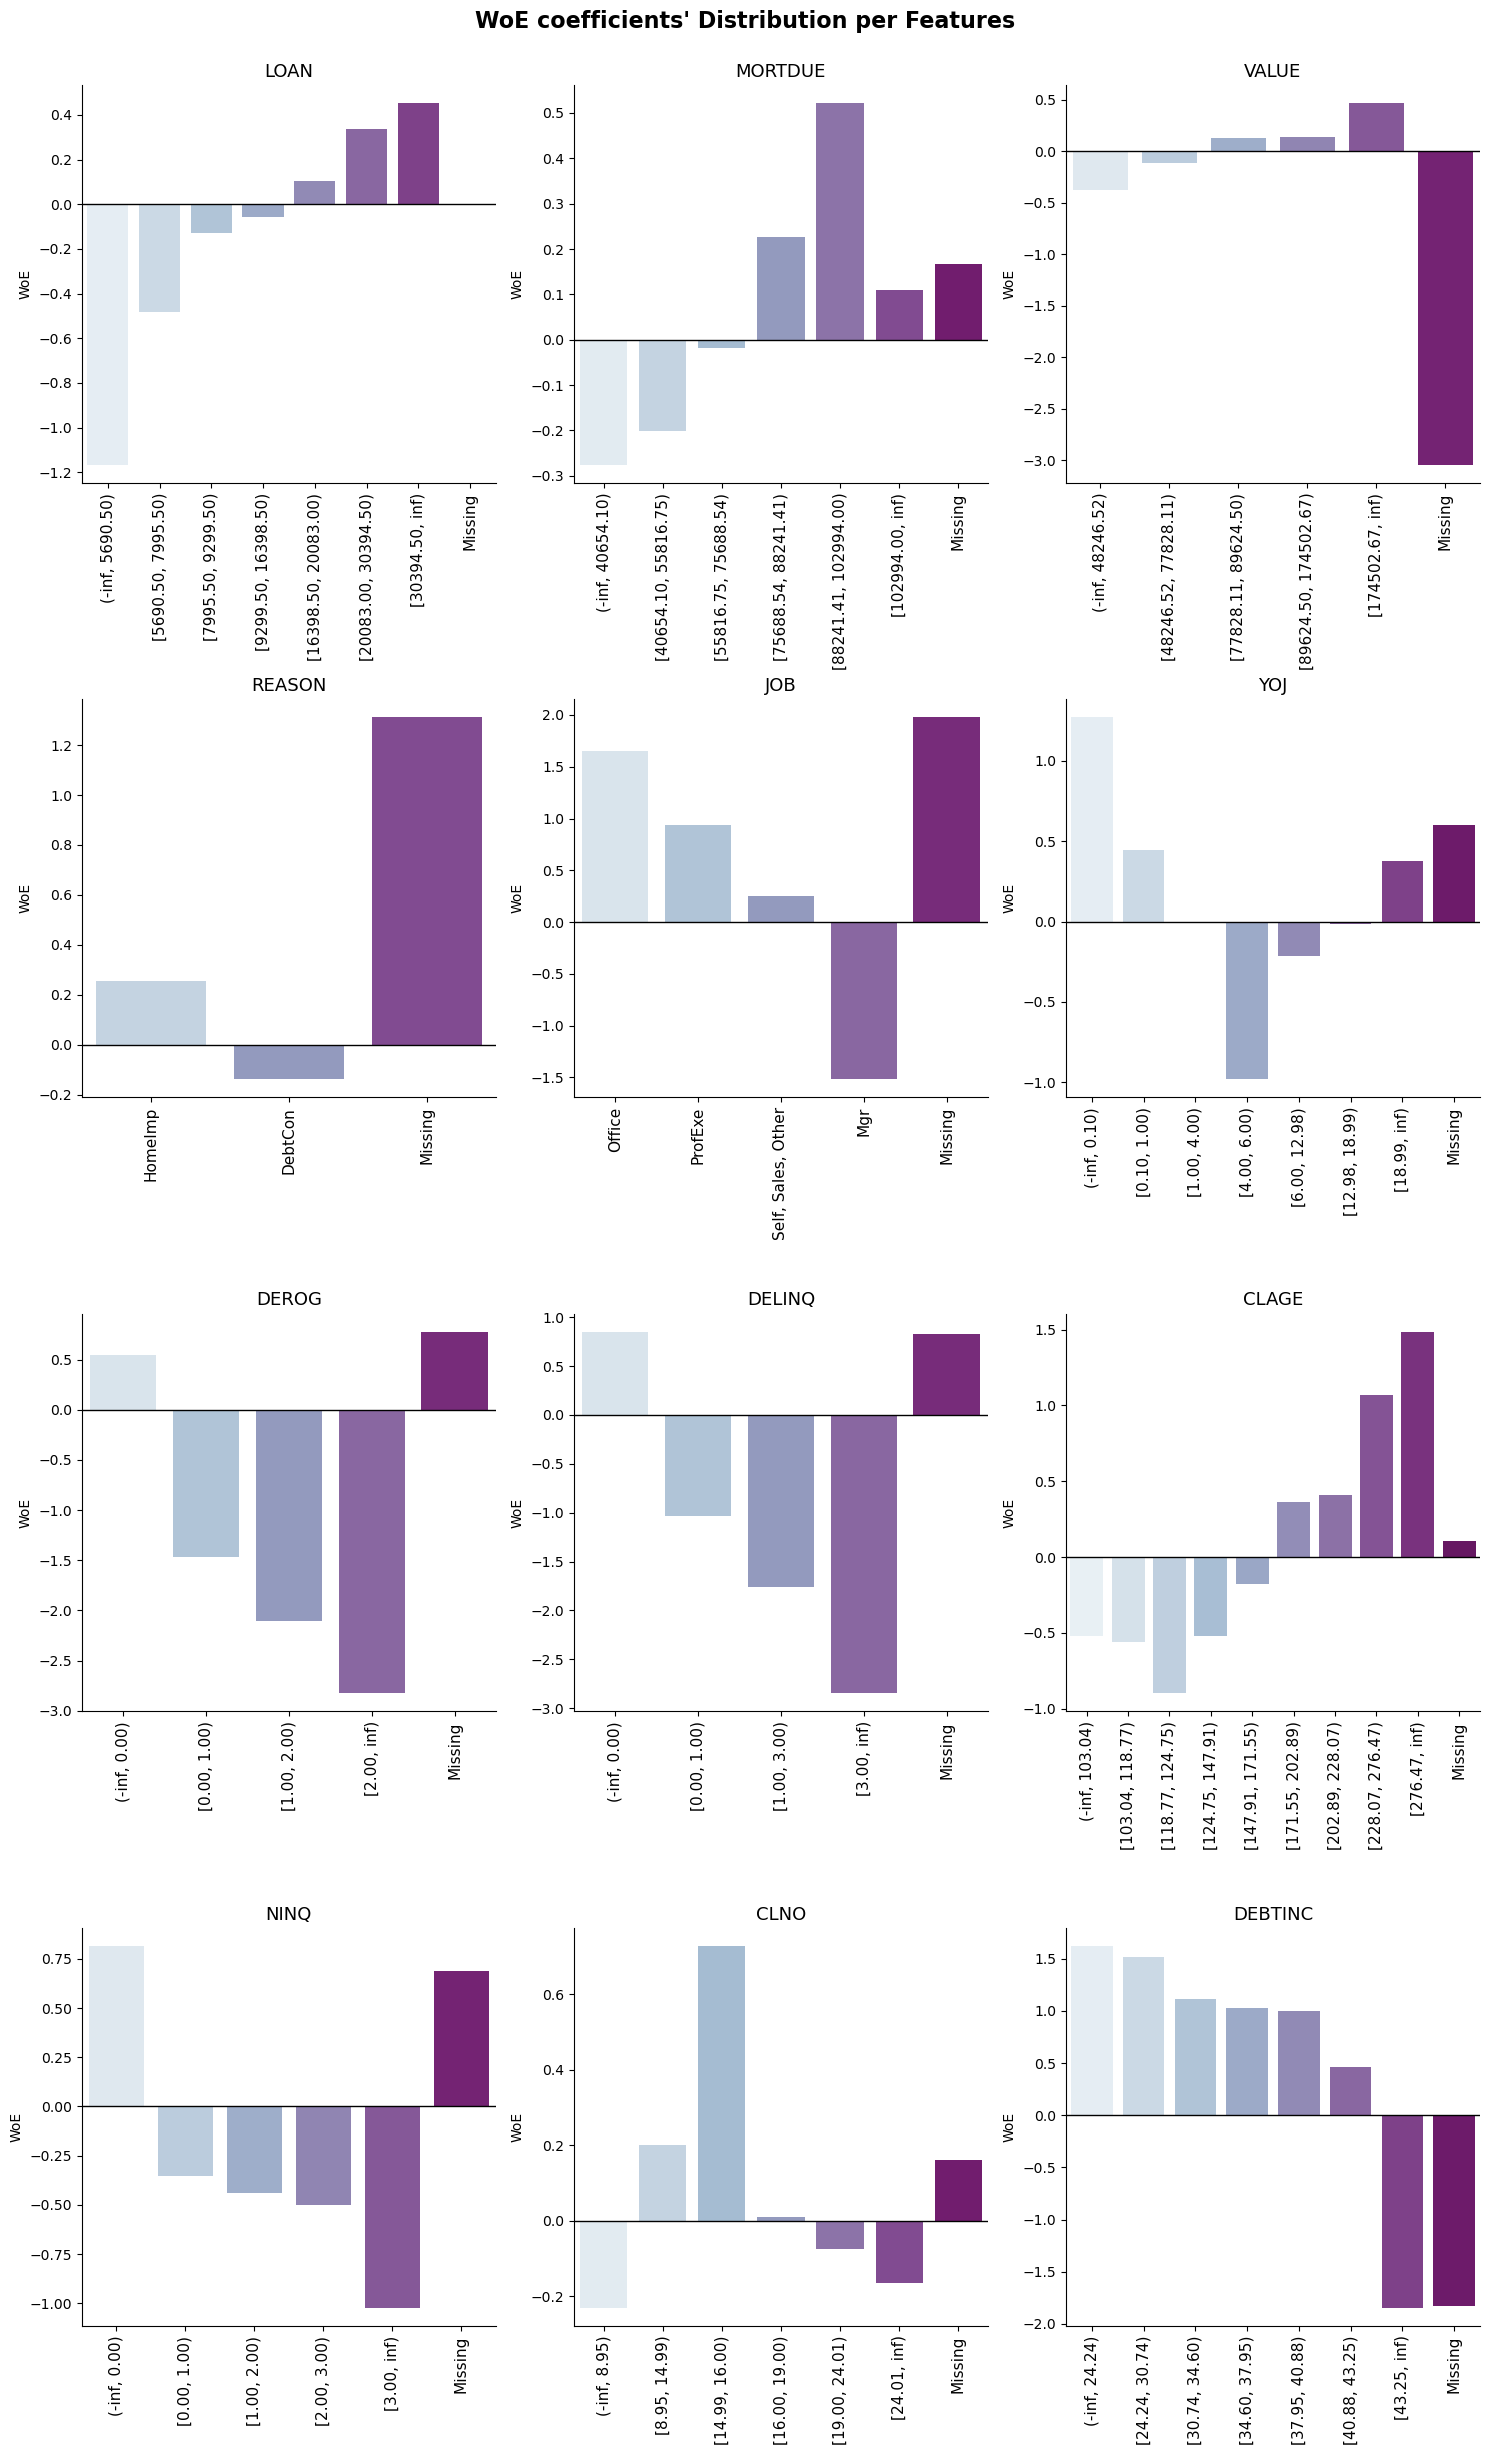

In [107]:
woe_bins_plot(woe_bins, export = False)

## **MODELLING**

Model space definition

In [108]:
models_dict = {
               "Logistic Regression": LogisticRegression(random_state = seed, n_jobs = -1),
               "Decisison Tree Classifier": DecisionTreeClassifier(random_state = seed),
               "Gaussian Naive Bayes": GaussianNB(),
               "K Neighbors Classifier": KNeighborsClassifier(n_jobs = -1), 
               "Random Forest Classifier": RandomForestClassifier(random_state = seed, n_jobs = -1),
               "Gradient Boosting Classifier": GradientBoostingClassifier(random_state = seed),
               "Support Vector Classifier": SVC(probability = True, random_state = seed),
               "Multi Layer Percepton Classifier": MLPClassifier(random_state = seed)
              }

Hyperparameter tuning using Bayesian Optimization
- With stratified 10-fold cross validation with 50 iterations while maximizing an objective function (F1 score).

In [109]:
def bayesian_optimization(model, x_train: pd.DataFrame, y_train:
                          pd.Series, seed: int, objective_function: str = "f1"):
    
    estimator = model

    #Adjustment of max_features hyperparameter within the final model selection.
    max_features = len(x_train.columns)

    #Defining a searching space of possible ranges of hyperparameters, given the model.
    
    if type(model) == type(RandomForestClassifier()):

        search_space = {
                        "n_estimators": Integer(100, 1000),
                        "criterion": Categorical(["gini", "entropy", "log_loss"]),
                        "max_depth": Integer(1, 10),
                        "max_features": Integer(1, max_features),
                        "class_weight": Categorical(["balanced", "balanced_subsample", None]),
                        "bootstrap": Categorical([True, False]),
                        "ccp_alpha": Real(0.000000000001, 0.5, prior="log-uniform"), 
                        }



    elif type(model) == type(GradientBoostingClassifier()):

        search_space = {
                        "n_estimators": Integer(100, 1000),
                        "loss": Categorical(["log_loss", "exponential"]),
                        "max_depth": Integer(1, 10),
                        "learning_rate":Real(0.0001, 0.2, prior="log-uniform"),
                        "max_features": Integer(1, max_features),
                        "criterion": Categorical(["friedman_mse", "squared_error"]),
                        }



    elif type(model) == type(LogisticRegression()):

        search_space = {
                        "fit_intercept": Categorical([True, False]),
                        "C": Real(0.000001, 5, prior = "log-uniform"),
                        "penalty": Categorical(["l1", "l2", "none", "elasticnet"]),
                        "solver": Categorical(["lbfgs", "liblinear", "newton-cg", "sag", "saga"]),
                        "class_weight": Categorical(["balanced", None])
                        }

        for solver in ["lbfgs", "liblinear", "newton-cg", "sag", "saga"]:
            if solver == "lbfgs" or solver == "newton-cg":
                search_space["penalty"] = Categorical(["l2", "none"])
            elif solver == "sag":
                search_space["penalty"] = Categorical(["l2", "elasticnet"])
                search_space["l1_ratio"] = Real(0, 1, prior = "uniform")
            elif solver == "liblinear":
                search_space["penalty"] = Categorical(["l1", "l2", "none", "elasticnet"])
                if search_space["penalty"] == "l2":
                    search_space["dual"] = Categorical([True, False])
                if search_space["fit_intercept"]:
                    search_space["intercept_scaling"] = Real(0.1, 100.0, prior="log-uniform")
            else:
                search_space["penalty"] = Categorical(["l1", "l2", "none", "elasticnet"])
                search_space["l1_ratio"] = Real(0, 1, prior = "uniform")
                search_space["solver"] = Categorical(["saga"])




    elif type(model) == type(SVC()):
        search_space = {
                        "C": Real(0.000001, 5, prior = "log-uniform"),
                        "kernel": Categorical(["linear", "poly", "rbf", "sigmoid"]),
                        "degree": Integer(1, 10),
                        "gamma": Categorical(["scale", "auto"]),
                        "shrinking": Categorical([True, False]),
                        "decision_function_shape": Categorical(["ovo", "ovr"]),
                        "tol": Real(1e-9, 1e-3, prior = "log-uniform"),
                        "class_weight": Categorical(["balanced", None])
                       }



    elif type(model) == type(MLPClassifier()):
        search_space = {
                        "hidden_layer_sizes": Integer(5, 500),
                        "activation": Categorical(["logistic", "identity", "tanh", "relu"]),
                        "solver": Categorical(["lbfgs", "sgd", "adam"]),
                        "learning_rate": Categorical(["constant", "invscaling", "adaptive"]),
                       }
        


    elif type(model) == type(DecisionTreeClassifier()):
        
        search_space = {
                        "criterion": Categorical(["gini", "entropy"]),
                        "max_depth": Integer(1, 10),
                        "max_features": Integer(1, max_features),
                        }  
        


    elif type(model) == type(GaussianNB()):

        search_space = {
                        "var_smoothing": Real(1e-9, 1e-6, prior = "log-uniform")
                       }



    elif type(model) == type(KNeighborsClassifier()):

        search_space = {
                        'n_neighbors': Integer(5, 20),
                        'weights':  Categorical(['uniform', 'distance']),
                        'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
                        'metric': Categorical(['minkowski', 'manhattan', 'euclidean', 'cityblock'])
                       }

        
    #Initialization of the stratified 10-fold cross validation.
    stratified_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

    #Initialization of the Bayesian Optimization.
        # using the stratified 10-fold cross validation and given model, while maximizing the objective function F1 score.
    bayescv = BayesSearchCV(estimator = estimator,
                            search_spaces = search_space,
                            scoring = objective_function, cv = stratified_cv,
                            n_jobs = -1, n_iter = 50,
                            random_state = seed)

    #Fitting the Bayesian optimization algorithm on the training data.
    bayescv.fit(x_train, y_train)

    #Outputs the model with the best tuned hyperparameters with respect to F1 score.
    return bayescv.best_estimator_

**Feature selection - Backward Sequential Feature Selection**
- for each base model, tune its hyperparameters with Bayesian Optimization.
  - Then use this tuned model as an input estimator within Forward Sequential Feature Selector to choose optimal subset of features.
- For $n$ models, we get $n$ subsets of optimal features.
- SFS uses stratified 10-fold cross validation while maximizing F1 score function.

In [110]:
def SFS_feature_selection(x_train:pd.DataFrame, y_train:pd.Series,
                   models_dict:dict, seed:int, objective_function: str = "f1", 
                   sfs_method: str = 'forward', export:bool = True) -> pd.DataFrame:
    
    #Printing output settings and functions
    dashes = 115 * "-"
    count = 1

    def print_FS(name: str, dashes: str,
                 count: int, models_dict: dict):

        print(dashes)
        order = f"{count}/{len(models_dict.keys())}"
        no_dashes_left = int((len(dashes) - len(order) - 1)/2)*"-"
        no_dashes_right  = f"{(len(dashes) - len(order) - len(no_dashes_left) - 2)*'-'}"
        print(f"{no_dashes_left} {order} {no_dashes_right}")
        print(dashes)

        text_ = f"FEATURE SELECTION WITH {name.upper()}"
        
        no_dashes_left_ = int((len(dashes) - len(text_) - 1)/2)*"-"
        no_dashes_right_  = f"{(len(dashes) - len(text_) - len(no_dashes_left_) - 2)*'-'}"
        print(f'{no_dashes_left_} {text_} {no_dashes_right_}')
        print(dashes)
        print(dashes, "\n")

    def print_FS_exec_time(time, number_features: int,
                        selected_feats: list, dashes: str):

        print(f'    Execution time: {round(time)} seconds', "\n")
        print(f'    {number_features} features selected: {", ".join(selected_feats)}', "\n")
        print(dashes)
        print(dashes, "\n")
        print()


    #Definitions of paths for exported files    
    opt_models_path = "./models/feature_selection/opt_models"
    feat_select_path = "./models/feature_selection/feat_select_objects"
    df_feat_select_path = "./models/feature_selection"
    
    #Empty list for storing all the models with their tuned hyperparameters, number of features selected, and names of selected features.
    models_feats_list = []

    #For each model, tune its hyperparameters using Bayesian Optimization.
        # Then use the tuned model for feature selection using Forward Sequential Feature Selector while maximizing an objective function F1 Score.
    for model_name, model in models_dict.items():

        print_FS(model_name, dashes, count, models_dict)

        start = time.time()
        print("    1/4 ... Starting Bayesian Optimization on the whole set of features")

        #Tuning the hyperparameters of the model using Bayesian Optimization.
        tuned_model = bayesian_optimization(model, x_train, y_train, seed, objective_function)

        print("    2/4 ... Bayesian Optimization finished")

        #Initialization of the stratified 10-fold cross validation.
        stratified_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

        print(f"    3/4 ... Starting {sfs_method.capitalize()} Sequential Feature Selection")

        #Initialization of the Forward Sequential Feature Selector 10-fold Cross Validation in order to select the optimal number of features.
            # based on the model with tuned hyperparameters and maximizing F1 score function.
            # Instead of selected a fixed number of features, we use an auto selection which stops adding features 
                # when the objective function (F1) is not incremented by at least "tol" between two consecutive feature additions.
                
        sfs = SequentialFeatureSelector(tuned_model, n_features_to_select = "auto",
                                        direction = sfs_method, scoring = objective_function,
                                        cv = stratified_cv, n_jobs = -1, tol = 0.0000000000000000001)
        sfs.fit(x_train, y_train)

        print(f"    4/4 ... {sfs_method.capitalize()} Sequential Feature Selection with finished", "\n")
        end = time.time()

        #Extracting the final selected features and number of the selected features.
        selected_feats = x_train.columns[sfs.get_support()].tolist()
        number_features = len(selected_feats)

        print_FS_exec_time(end - start, number_features, selected_feats, dashes)

        #Exporting both fitted tuned model and feature selection object.
        if export:
            for save_path, export_obj, save_name in zip([opt_models_path, feat_select_path],
                                                        [tuned_model, sfs],
                                                        ["FS_tuned", "SFS_with"]):
        
                os.makedirs(save_path, exist_ok = True)
                with open(f'{save_path}/{save_name}_{"".join([i[0] for i in model_name.split(" ")])}.h5', "wb") as save_obj:
                    pickle.dump(export_obj, save_obj)

        #Appeding all the model's information from both Bayesian Optimization an Sequential Feature Selection.
        models_feats_list.append([model_name, #name of the tuned base model
                                  tuned_model, #tuned base model
                                  sfs, #fitted SFS object
                                  number_features, #number of selected features
                                  selected_feats, #list of selected features' names
                                  end - start #execution time
                                  ])

        count += 1
        
    #Storing all the models with their tuned hyperparameters, number of features selected, and names of selected features.
    feat_sel_cols = ["model_name", "model", "sfs_model",
                     "n_features", "final_features", "execution_time"]

    feat_sel = pd.DataFrame(models_feats_list, columns = feat_sel_cols)
    
    #Exporting the data frame storing all the models' information from both Bayesian Optimization an Sequential Feature Selection.
    if export:
        with open(f"{df_feat_select_path}/feat_selection_df_ORIGINAL.pkl", "wb") as feat_select_df_save:
            pickle.dump(feat_sel, feat_select_df_save)

    return feat_sel

In [111]:
feat_selection_df = SFS_feature_selection(X_train_binned, y_train, models_dict, seed)

-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- 1/8 -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
------------------------------------ FEATURE SELECTION WITH LOGISTIC REGRESSION -----------------------------------
-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------- 

    1/4 ... Starting Bayesian Optimization on the whole set of features
    2/4 ... Bayesian Optimization finished
    3/4 ... Starting Forward Sequential Feature Selection
    4/4 ... Forward Sequential Feature Selection with finished 

    Execution time: 93 seconds 

    7 features selected: VALUE,

In [112]:
feat_selection_df

,model_name,model,sfs_model,n_features,final_features,execution_time
0,Logistic Regression,"LogisticRegression(C=0.2270829472531271, class...",SequentialFeatureSelector(cv=StratifiedKFold(n...,7,"[VALUE, REASON, JOB, DEROG, DELINQ, CLAGE, DEB...",92.652117
1,Decisison Tree Classifier,"DecisionTreeClassifier(max_depth=10, max_featu...",SequentialFeatureSelector(cv=StratifiedKFold(n...,9,"[VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, ...",47.509489
2,Gaussian Naive Bayes,GaussianNB(var_smoothing=1.6994636371262764e-08),SequentialFeatureSelector(cv=StratifiedKFold(n...,6,"[MORTDUE, JOB, DELINQ, CLAGE, NINQ, DEBTINC]",22.524822
3,K Neighbors Classifier,"KNeighborsClassifier(algorithm='kd_tree', metr...",SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG...",78.296545
4,Random Forest Classifier,(DecisionTreeClassifier(ccp_alpha=2.7573273286...,SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, MORTDUE, REASON, JOB, YOJ, DEROG, DELIN...",819.495343
5,Gradient Boosting Classifier,([DecisionTreeRegressor(criterion='friedman_ms...,SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ...",2958.111637
6,Support Vector Classifier,"SVC(C=4.999999999999999, class_weight='balance...",SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG...",1430.620819
7,Multi Layer Percepton Classifier,"MLPClassifier(hidden_layer_sizes=402, learning...",SequentialFeatureSelector(cv=StratifiedKFold(n...,10,"[MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ, CLAG...",4613.324874


Recurrence of the selected features
- As can be seen, CLAGE, DEBTINC, DELINQ and JOB were selected by each base model.

In [113]:
def selected_features_recurrence(df: pd.DataFrame, export: bool = True):
    
    df_plot = (
                pd.get_dummies(df["final_features"]
                               .apply(pd.Series)
                               .stack()
                              )
                .sum(level = 0)
                .sum()
                .reset_index()
                .rename(columns = {"index": "Model", 0: "Count"})
                .sort_values("Count", ascending = False)
              )
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))

    
    
    df_plot.plot.bar(x = "Model", y = "Count", color = "mediumpurple",
                     legend = False, ax = ax, zorder = 2)
    
    ax.grid(which = "major", axis = "y", linestyle = "--", zorder = 0)
    
    
    # set title and axis labels
    plt.title("Recurrence of the selected features", size = 13, fontweight = "bold")
    plt.xlabel("Features", size = 11)
    plt.ylabel("Count", size = 11)
    plt.yticks(range(1, df_plot['Count'].max() + 1), size = 11)
    plt.xticks(rotation = 45, size = 11)
    
    plt.legend().set_visible(False)
    
        #Removing upper and right axes spines
    axes = plt.gca()
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)

    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/Recurrence_Selected_Features.jpg", dpi = 300)

    plt.show()

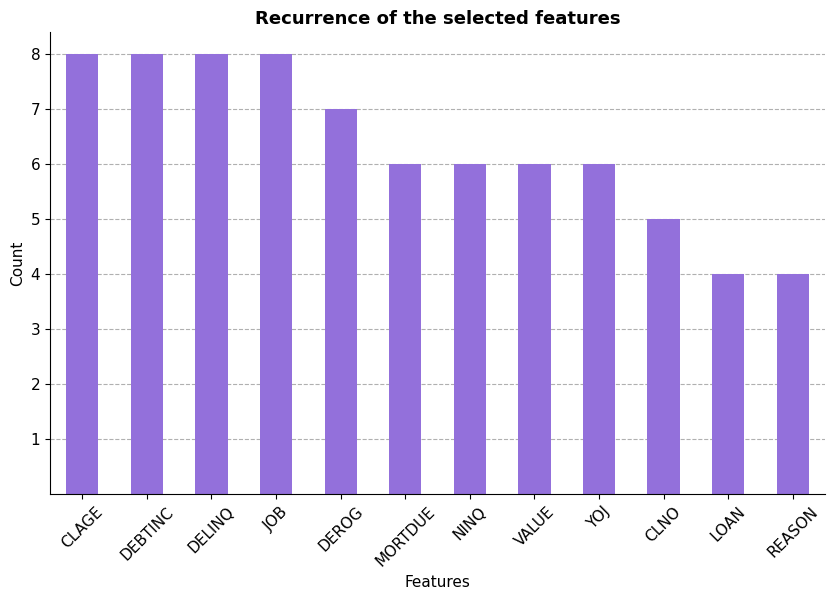

In [114]:
selected_features_recurrence(feat_selection_df)

Distribution of selected features per model

In [115]:
def selected_features_dist(df: pd.DataFrame, export: bool = True):

    df_plot = (
               pd.concat(
                         (
                          df[["model_name"]],
                          pd.get_dummies(
                                         df["final_features"]
                                         .apply(pd.Series)
                                         .stack()
                                        )
                          .sum(level = 0)
                         ),
                         axis = 1
                        )
               .copy()
              )
    
    df_plot["totals"] = df_plot.drop("model_name", axis = 1).sum(axis = 1)
    df_plot["model_name"] = df_plot["model_name"].str.replace("Classifier", "")
    
    df_plot = (
                df_plot
                .sort_values(by = "totals",
                             ascending = False)
                .drop("totals", axis = 1)
              )
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))

    df_plot.plot(
                 x = "model_name",
                 y = [col for col in df_plot.columns if col != "model_name"],
                 kind = "bar",
                 stacked = True,
                 figsize = (10,6),
                 ax = ax,
                 zorder = 3
                )
    
    ax.grid(which = "major", axis = "y", linestyle = "--", zorder = 0)
    plt.title("Distribution of selected features", size = 15, fontweight = "bold")
    plt.xlabel("Model", size = 11)
    plt.ylabel("Number of selected features", size = 11)
    plt.xticks(rotation = 70, size = 11)
    plt.yticks(range(1,
                     df_plot[[col for col in df_plot.columns if col != "model_name"]].sum(axis = 1).max() + 1),
                     size = 11)
    plt.legend(bbox_to_anchor = (1, 1))
    
    #Removing upper and right axes spines
    axes = plt.gca()
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)


    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/Selected_Features_Distribution.jpg", dpi = 300)
        
    plt.show()

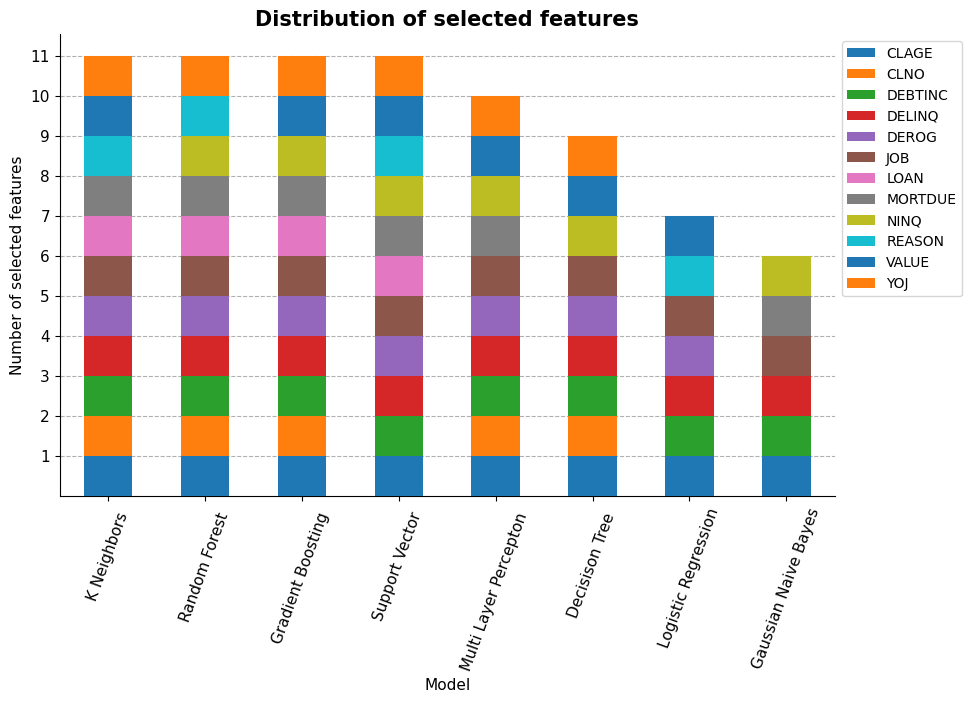

In [116]:
selected_features_dist(feat_selection_df)

Used in such case where multiple models selected the same features

In [117]:
def remove_duplicated_selected_feats(df:pd.DataFrame, export:bool = True) -> pd.DataFrame:

   df_feat_select_path = "./models/feature_selection"
   
   #Filtering indices of duplicated selected features
   feat_duplicated_ind = (
                            df["final_features"]
                           .apply( lambda x: ", ".join(x))
                           .duplicated(keep = False)
                           .values
                          )
   
   if sum(feat_duplicated_ind) != 0:
      #Keeping the model which was the fastest to execute and drop the others
      duplicated_models = (
                           df[feat_duplicated_ind]
                           .sort_values("execution_time")
                           .reset_index(drop = True)
                        )
    
      drop_models = (
                   duplicated_models
                   .loc[1:,'model_name']
                   .values
                  )
      
      keep_model = duplicated_models.head(1)["model_name"].values[0]

      models_name_join = ', '.join(duplicated_models["model_name"].tolist())
      
      final_feat_selection_df = (
                                df[~df["model_name"].isin(drop_models)]
                                .reset_index(drop = True)
                                )
      
      final_feat_selection_df.loc[final_feat_selection_df["model_name"] == keep_model, "model_name"] = models_name_join
      
   else:
      final_feat_selection_df = df.copy()

   if export:
      with open(f"{df_feat_select_path}/feat_selection_df_FINAL.pkl", "wb") as feat_select_df_save:
         pickle.dump(final_feat_selection_df, feat_select_df_save)

   return final_feat_selection_df

In [118]:
feat_selection_df_FINAL = remove_duplicated_selected_feats(feat_selection_df)

In [119]:
feat_selection_df_FINAL[["model_name", "n_features", "final_features", "execution_time"]]

,model_name,n_features,final_features,execution_time
0,Logistic Regression,7,"[VALUE, REASON, JOB, DEROG, DELINQ, CLAGE, DEB...",92.652117
1,Decisison Tree Classifier,9,"[VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, ...",47.509489
2,Gaussian Naive Bayes,6,"[MORTDUE, JOB, DELINQ, CLAGE, NINQ, DEBTINC]",22.524822
3,K Neighbors Classifier,11,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG...",78.296545
4,Random Forest Classifier,11,"[LOAN, MORTDUE, REASON, JOB, YOJ, DEROG, DELIN...",819.495343
5,Gradient Boosting Classifier,11,"[LOAN, MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ...",2958.111637
6,Support Vector Classifier,11,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG...",1430.620819
7,Multi Layer Percepton Classifier,10,"[MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ, CLAG...",4613.324874


**Model selection**
- Take each base model, tune its hyperparameters using Bayesian Optimization on each subset of selected features (in the previous step) while maximizing F1 score function,
  - and then, use this tuned model and evaluate it on a validation set.
- Thus, when having $n$ base models and $m$ subset of features, we get $n \times m$ models.
  - where $m \le n$ and is set of unique subsets of selected features.
- We compute several evaluation metrics such as Recall, we also calculate F1, Precision, Accuracy, AUC, Gini, Kolmogorov-Smirnov, Somers' D, Matthews Coefficient, Jaccard Score, Brier Score Loss, Hamming Loss and Zero-One Loss.
- By default, the classification threshold is 0.5, which doesn't have to be valid in practice.
  - Therefore, we calculate an optimal threshold using Youden index which looks for such threshold which maximize:
  $$TPR + TNR - 1$$
- In order to choose the final model, we rank the models in accordance with the calculated metrics and the weights assigned to metric.
  - The default weight is 1 and the higher weight is, the higher importance is assigned within ranking.
  - The model with the 1st rank is then chosen as the final model.

In [120]:
metrics_weights = {
                    "ascending_rank": {
                                        "F1": 1.5,
                                        "Recall": 1.2,
                                        "Precision": 1,
                                        "Accuracy": 1,
                                        "AUC": 1,
                                        "Somers D": 1,
                                        "KS": 1,
                                        "MCC": 1,
                                        "Jaccard Score": 1,
                                       },

                    "descending_rank": {
                                        "Brier Score Loss": 1,
                                        "Hamming Loss": 1,
                                        "Zero-One Loss": 1,
                                       }
                    }

Function for calculating optimal threshold using Youden index

In [ ]:
def calc_opt_threshold(model, x:pd.DataFrame, y:pd.Series) -> float:

    y_scores = model.predict_proba(x)[:, 1]

    fpr, tpr, thresholds = roc_curve(y, y_scores)

    youden_index = tpr + (1 - fpr) - 1
    threshold = thresholds[np.argmax(youden_index)]

    return threshold

In [121]:
def model_selection(x_train:pd.DataFrame, y_train:pd.Series,
                    x_val:pd.DataFrame, y_val:pd.Series,
                    models_dict:dict, feat_sel:pd.DataFrame,
                    seed:int, metrics_weights:dict,
                    target:str = "BAD", objective_function: str = "f1",
                    export:bool = True) -> pd.DataFrame:
    

    #Printing output settings functions
    dashes = 115 * "-"
    count = 1

    def print_model_selection(name: str, fs_name: str, feat_sel: pd.DataFrame,
                              models_dict: dict, dashes: str, count: int):
        
        print(dashes)

        order = f"{count}/{len(models_dict.keys())*feat_sel.shape[0]}"
        no_dashes_left = int((len(dashes) - len(order) - 1)/2)*"-"
        no_dashes_right  = f"{(len(dashes) - len(order) - len(no_dashes_left) - 2)*'-'}"

        print(f"{no_dashes_left} {order} {no_dashes_right}")

        print(dashes)

        text_ = f"BAYESIAN OPTIMIZATION OF {name.upper()}"
        text__ = f"WITH FEATURES SELECTED BY {fs_name.upper()}"
            
        no_dashes_left_ = int((len(dashes) - len(text_) - 1)/2)*"-"
        no_dashes_right_  = f"{(len(dashes) - len(text_) - len(no_dashes_left_) - 2)*'-'}"
        no_dashes_left__ = int((len(dashes) - len(text__) - 1)/2)*"-"
        no_dashes_right__  = f"{(len(dashes) - len(text__) - len(no_dashes_left__) - 2)*'-'}"     

        print(f"{no_dashes_left_} {text_} {no_dashes_right_}")
        print(f"{no_dashes_left__} {text__} {no_dashes_right__}")
        print(dashes)
        print(dashes, "\n")
    

    def exec_time_model_selection(name: str, opt_mod, time, evs_list: list,
                                  threshold: float, dashes: str):
        
        print(f"    Execution time: {round(time)} seconds", "\n")
        print(f"    {objective_function.capitalize()} Score on Validation set: {evs_list[0]}", "\n")
        print(f"    Optimal classification threshold: {round(threshold, 4)}", "\n")
        print(f"   Tuned hyperparameters of {name}:", opt_mod.get_params(), "\n")
        print(dashes, "\n")
    
    #Path to save the model selection data frame.
    model_selection_path = "./models/model_selection"

    #Metrics space.
    metrics = { 
                "F1": f1_score,
                "Precision": precision_score, 
                "Recall": recall_score, 
                "Accuracy": accuracy_score,
                "AUC": roc_auc_score,
                "Somers D": somersd,
                "KS": ks_2samp, 
                "MCC": matthews_corrcoef,
                "Jaccard Score": jaccard_score,
                "Brier Score Loss": brier_score_loss,
                "Zero-One Loss": zero_one_loss,
                "Hamming Loss": hamming_loss
                }
    
    #Metrics categorization
    probs_evs = ["AUC", "Brier Score Loss"]
    class_evs = ["Precision", "Recall", "F1", "Accuracy", "MCC", "Zero-One Loss", "Jaccard Score", "Hamming Loss"]
    
    #List for storing the results of the model selection.
    tuned_list = []


    #For each model, optimize it on the each subset of optimal features on training set
        # and then evaluate it on validation set with filtered features (using set of several metrics).
    for model_name, model in models_dict.items():
        
        for _, row in feat_sel.iterrows():
            
            #Model name and feature selection method.
            fs_name, fs_mod, sfs = row["model_name"], row["model"], row["sfs_model"]

            #Final features
            final_features = row["final_features"]

            #Filtered training and validation sets based on the final features.
            X_train_filtered = x_train[final_features]
            X_val_filtered = x_val[final_features]

            print_model_selection(model_name, fs_name, feat_sel, models_dict, dashes, count)

            print(f"    1/2 ... Starting Bayesian Optimization on the subset of features ({len(final_features)} features):")
            print(f'               {", ".join(final_features)}')

            start = time.time()

            #Bayesian Optimization
            tuned_model = bayesian_optimization(model, X_train_filtered, y_train, seed, objective_function)

            end = time.time()

            #Optimal threshold calculation
            threshold = calc_opt_threshold(tuned_model, X_train_filtered, y_train)
            
            #Predicted probabilities and classes on validation set (using optimal threshold)
            y_val_scores = tuned_model.predict_proba(X_val_filtered)[:, 1]
            y_val_preds = pd.Series(y_val_scores).apply(lambda x: 1 if x > threshold else 0)

            #List for storing calculated evaluation metrics.
            evs_list = []

            #Metrics calculation on validation set.
            for metric_name, metric in metrics.items():
                if metric_name in probs_evs:
                    evs_list.append(metric(y_val, y_val_scores))
                elif metric_name in class_evs:
                    evs_list.append(metric(y_val, y_val_preds))
                elif metric_name == "Somers D":
                    evs_list.append(metric(y_val, y_val_scores).statistic)
                elif metric_name == "KS":
                    X_Y_concat = pd.concat((y_val, X_val_filtered), axis = 1)
                    X_Y_concat["prob"] =  y_val_scores
                    evs_list.append(metric(X_Y_concat.loc[X_Y_concat[target] == 1, "prob"],
                                           X_Y_concat.loc[X_Y_concat[target] == 0, "prob"]).statistic)

            #Storing the results of the model selection.
            tuned_list.append([model_name,
                               fs_name,
                               tuned_model,
                               fs_mod,
                               sfs,
                               len(final_features),
                               final_features,
                               end - start,
                               threshold] + 
                               evs_list
                               )

           #Exporting the final tuned model in .h5 format 
            if export:
                os.makedirs(model_selection_path, exist_ok = True)
                os.makedirs(f"{model_selection_path}/models", exist_ok = True)

                #Tuned model within SFS - Removing spaces in the model's name and replacing commas with underscores in case there are more models in the name
                save_fs_name = "_".join([''.join(j[0] for j in i.split()) for i in fs_name.split(', ')])

                #Final tuned model - Removing spaces in the model's name
                save_tuned_name = "".join([i[0] for i in model_name.split(" ")])

                with open(f"{model_selection_path}/models/{save_tuned_name}_with_{save_fs_name}.h5", "wb") as mod_save:
                    pickle.dump(tuned_model, mod_save)

            
            print("    2/2... Bayesian Optimization finished", "\n")

            exec_time_model_selection(model_name, tuned_model, end - start, evs_list, threshold, dashes)

            count += 1

    #Model selection data frame.
    model_sel_cols = ["tuned_model_name", "fs_model_name",
                      "tuned_model", "fs_model",
                      "sfs_object", "n_features",
                      "final_features", "execution_time",
                      "threshold"] + list(metrics.keys())
    
    model_selection_df = pd.DataFrame(tuned_list, columns = model_sel_cols)
            
    #Ranking the models based on the evaluation metrics and the provided weights.
    for dict_name, metric_weight_dict in metrics_weights.items():

        #Ranking each metric.
        for metric, weight in metric_weight_dict.items():
                
                #ranking the models whether the metric is ascending or descending (score metrics are ascending, loss metrics are descending).
                order = True if dict_name == "ascending_rank" else False

                #Ranking
                model_selection_df[f"{metric}_rank"] = (
                                                        model_selection_df[[metric]]
                                                        .rank(ascending = order)
                                                        .apply(lambda rank: rank * weight)
                                                        )
    
    #Accessing individual ranking metrics columns.
    ranked_cols = [rank for rank in model_selection_df.columns if "_rank" in rank]

    #Final ranking based on individual rankings
    model_selection_df["rank"] = (
                                    model_selection_df[ranked_cols]
                                    .sum(axis = 1)
                                    .rank(ascending = False)
                                  )

    #Ordering the model selection data frame based on the final ranking.
    model_selection_df = (
                           model_selection_df
                          .drop(ranked_cols, axis = 1)
                          .sort_values("rank")
                          .reset_index(drop = True)
                          )
    
    #Exporting the model selection data frame.
    if export:
        with open(f"{model_selection_path}/model_selection_df.pkl", "wb") as model_select_df_save:
            pickle.dump(model_selection_df, model_select_df_save)

    return model_selection_df

In [122]:
model_selection_df = model_selection(X_train_binned, y_train, X_valid_binned, y_valid,
                                     models_dict, feat_selection_df_FINAL, seed, metrics_weights)

-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- 1/64 ------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
----------------------------------- BAYESIAN OPTIMIZATION OF LOGISTIC REGRESSION ----------------------------------
---------------------------------- WITH FEATURES SELECTED BY LOGISTIC REGRESSION ----------------------------------
-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------- 

    1/2 ... Starting Bayesian Optimization on the subset of features (7 features):
               VALUE, REASON, JOB, DEROG, DELINQ, CLAGE, DEBTINC
    2/2... Bayesian Optimization finis

In [123]:
model_selection_df.loc[:, ~model_selection_df.columns.isin(['tuned_model', 'fs_model', 'sfs_object', 'final_features'])]

,tuned_model_name,fs_model_name,n_features,execution_time,threshold,F1,Precision,Recall,Accuracy,AUC,Somers D,KS,MCC,Jaccard Score,Brier Score Loss,Zero-One Loss,Hamming Loss,rank
0,Gradient Boosting Classifier,K Neighbors Classifier,11,814.546601,0.507240,0.797784,0.791209,0.804469,0.918436,0.958733,0.917465,0.798883,0.746744,0.663594,0.068683,0.081564,0.081564,1.0
1,Gradient Boosting Classifier,Support Vector Classifier,11,950.780469,0.505329,0.789625,0.815476,0.765363,0.918436,0.955463,0.910927,0.796089,0.739671,0.652381,0.071751,0.081564,0.081564,2.0
2,Gradient Boosting Classifier,Multi Layer Percepton Classifier,10,775.991061,0.495533,0.780899,0.785311,0.776536,0.912849,0.951484,0.902968,0.775140,0.726526,0.640553,0.066649,0.087151,0.087151,3.0
3,Gradient Boosting Classifier,Gradient Boosting Classifier,11,723.208943,0.413219,0.779944,0.777778,0.782123,0.911732,0.954301,0.908601,0.798883,0.724743,0.639269,0.070320,0.088268,0.088268,4.0
4,Gradient Boosting Classifier,Random Forest Classifier,11,853.294345,0.497272,0.777465,0.784091,0.770950,0.911732,0.954074,0.908149,0.796089,0.722458,0.635945,0.066885,0.088268,0.088268,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Gaussian Naive Bayes,Multi Layer Percepton Classifier,10,22.784548,0.219365,0.601336,0.500000,0.754190,0.800000,0.849279,0.698558,0.576816,0.492950,0.429936,0.131920,0.200000,0.200000,60.0
60,Gaussian Naive Bayes,Gaussian Naive Bayes,6,22.496297,0.478674,0.594966,0.503876,0.726257,0.802235,0.835574,0.671148,0.555866,0.483478,0.423453,0.147009,0.197765,0.197765,61.0
61,Logistic Regression,Gaussian Naive Bayes,6,93.461143,0.456093,0.594848,0.512097,0.709497,0.806704,0.837891,0.675783,0.553073,0.483062,0.423333,0.131867,0.193296,0.193296,62.0
62,Gaussian Naive Bayes,Support Vector Classifier,11,22.453375,0.199121,0.588496,0.487179,0.743017,0.792179,0.842506,0.685013,0.571229,0.475641,0.416928,0.134489,0.207821,0.207821,63.0


Distribution of metrics

In [282]:
def plot_models_metrics(df: pd.DataFrame, metric: str, group_by: str = "tuned_model_name", plot_name: str = '', export:bool = True):

    plt.figure(figsize = (7, 4))
    sns.boxplot(data = df, x = metric, y = group_by)

    plt.title(f"{metric.upper()} Distribution", fontsize = 13, fontweight = "bold")

    axes = plt.gca()
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    axes.set(ylabel = None)

    if export:
        os.makedirs("./plots/", exist_ok = True)
        plot_name_save = metric.upper() if len(plot_name) == 0 else plot_name.upper()
        plt.savefig(f"./plots/{plot_name_save}_Distribution.jpg", dpi = 300)
    
    plt.show()


We can observe that F1 scores ranges from 0.6 to 0.8, with an exception of the outliers in KNN.

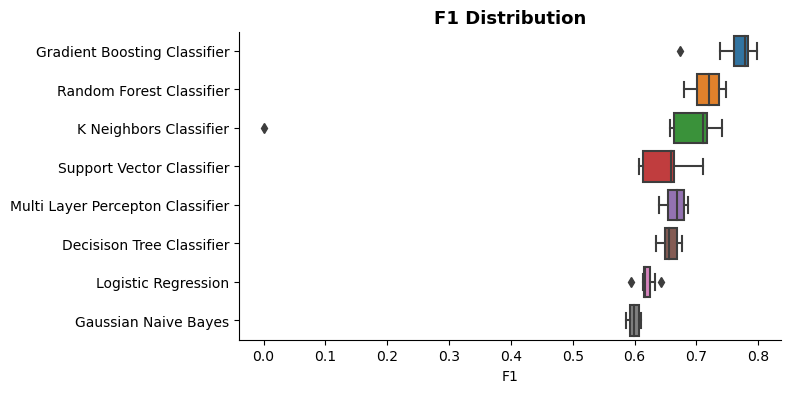

In [283]:
plot_models_metrics(model_selection_df, "F1")

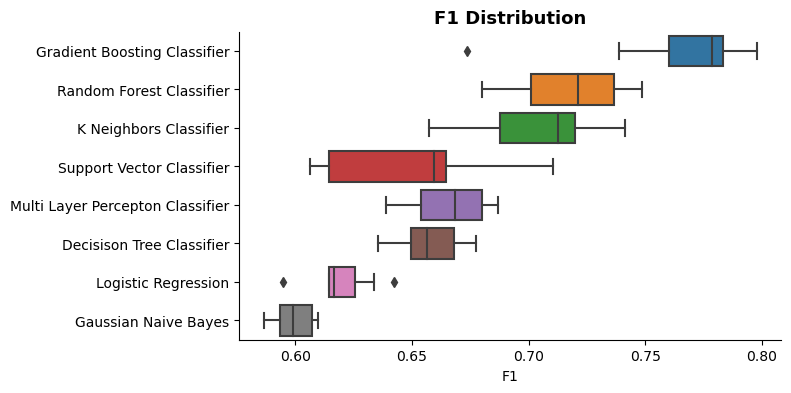

In [284]:
plot_models_metrics(model_selection_df[model_selection_df["F1"] > model_selection_df["F1"].min()],
                    "F1", plot_name = "F1_wo_outliers")

Distribution of thresholds - most of the tresholds were below 0.5, thus the models are more conservative (with an exception of the outlier in KNN)

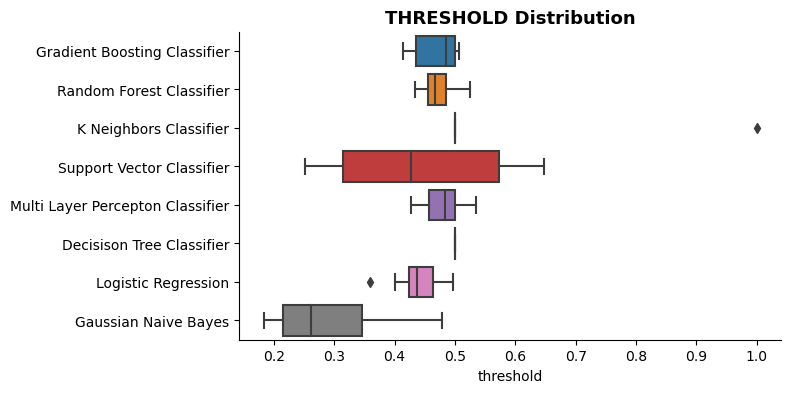

In [285]:
plot_models_metrics(model_selection_df, "threshold")

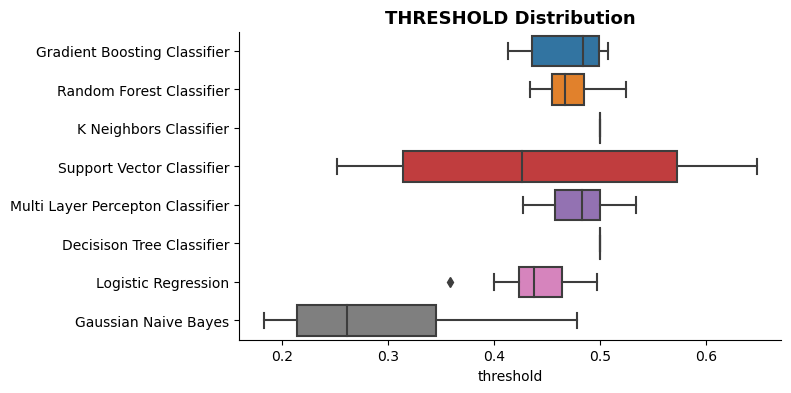

In [287]:
plot_models_metrics(model_selection_df[model_selection_df["threshold"] < model_selection_df["threshold"].max()],
                    "threshold", plot_name = "threshold_wo_outliers")

As can se seen, the MLP took the most time to optimize compared to the other models, nevertheless it was outperfomed by several models which took less time for training.
- On the other hand, LR, GNB or DT took the least amount of time to optimize.

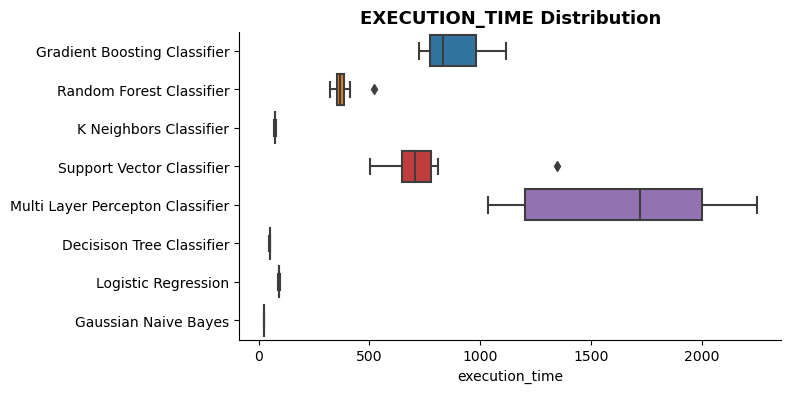

In [286]:
plot_models_metrics(model_selection_df, "execution_time")

Other metrics' distribution - as expected the final model (GBC) has the highest score metrics / lowest loss metrics.

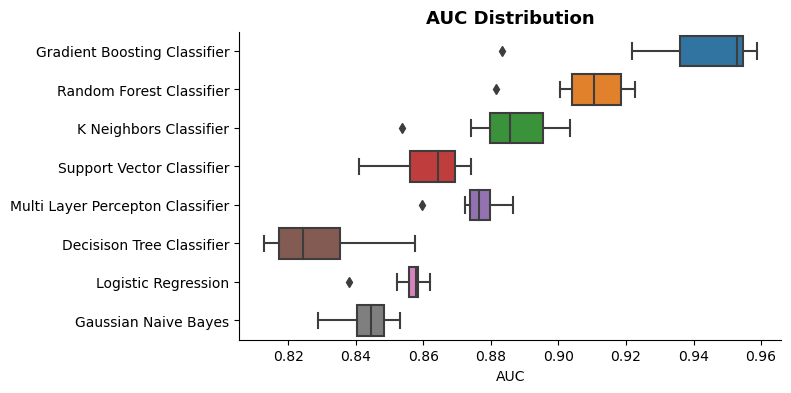

In [288]:
plot_models_metrics(model_selection_df, "AUC", export = False)

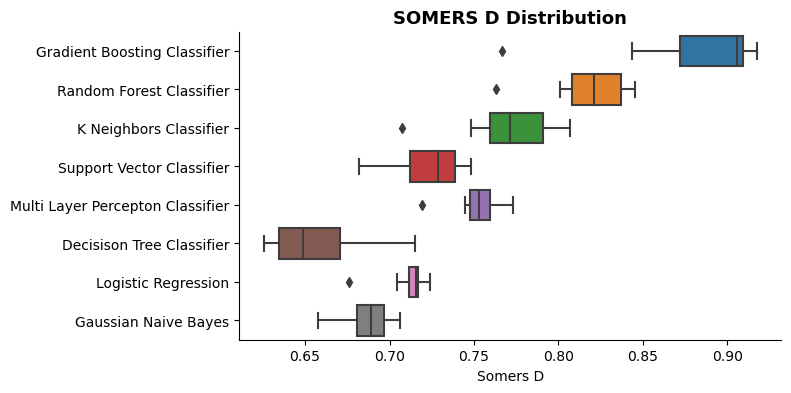

In [289]:
plot_models_metrics(model_selection_df, "Somers D", export = False)

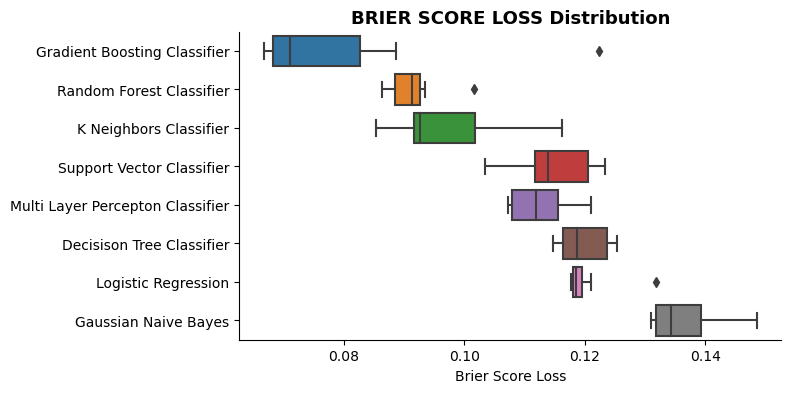

In [290]:
plot_models_metrics(model_selection_df, 'Brier Score Loss', export = False)

Aggregated ranking of models

In [263]:
def model_selection_agg_rank(df: pd.DataFrame, metric: str = 'F1', model_agg = "tuned_model"):

    descending_order = ['F1', 'Precision', 'Recall', 'Accuracy', 'AUC', 'Somers D', 'KS', 'MCC', 'Jaccard Score']
    ascending_order = ['Brier Score Loss', 'Zero-One Loss', 'Hamming Loss', 'execution_time']
    
    if metric in descending_order:
        order = [False, False, False]
        agg_min_max = "max"
    elif metric in ascending_order:
        order = [True, True, True]
        agg_min_max = "min"
    
    ranked_agg_df = (df
                     .groupby(f"{model_agg}_name")[metric]
                     .agg(**{f"{metric}_median": "median",
                             f"{metric}_mean": "mean",
                             f"{metric}_{agg_min_max}": agg_min_max})
                     .sort_values([f'{metric}_median', f'{metric}_mean', f'{metric}_{agg_min_max}'],
                                  ascending = order)
                    )
    
    for col in ranked_agg_df.columns:
        ranked_agg_df[f"{col}_rank"] = ranked_agg_df[col].rank(ascending = order[0])

    return ranked_agg_df

In [264]:
model_selection_agg_rank(model_selection_df)

,F1_median,F1_mean,F1_max,F1_median_rank,F1_mean_rank,F1_max_rank
tuned_model_name,,,,,,
Gradient Boosting Classifier,0.778705,0.763205,0.797784,1.0,1.0,1.0
Random Forest Classifier,0.720974,0.718178,0.748634,2.0,2.0,2.0
K Neighbors Classifier,0.710749,0.615815,0.741333,3.0,7.0,3.0
Multi Layer Percepton Classifier,0.668367,0.666235,0.686813,4.0,3.0,5.0
Support Vector Classifier,0.659280,0.649395,0.710227,5.0,5.0,4.0
Decisison Tree Classifier,0.656540,0.657400,0.677249,6.0,4.0,6.0
Logistic Regression,0.616631,0.619511,0.642336,7.0,6.0,7.0
Gaussian Naive Bayes,0.599143,0.599202,0.609865,8.0,8.0,8.0


In [265]:
model_selection_agg_rank(model_selection_df, model_agg = 'fs_model')

,F1_median,F1_mean,F1_max,F1_median_rank,F1_mean_rank,F1_max_rank
fs_model_name,,,,,,
Multi Layer Percepton Classifier,0.697802,0.685137,0.780899,1.0,2.0,3.0
Decisison Tree Classifier,0.678350,0.682463,0.767507,2.0,3.0,6.0
Support Vector Classifier,0.670579,0.673684,0.789625,3.0,5.0,2.0
Logistic Regression,0.670262,0.675214,0.738786,4.0,4.0,7.0
K Neighbors Classifier,0.668833,0.688926,0.797784,5.0,1.0,1.0
Random Forest Classifier,0.655728,0.658674,0.777465,6.0,6.0,5.0
Gradient Boosting Classifier,0.648558,0.587049,0.779944,7.0,8.0,4.0
Gaussian Naive Bayes,0.643494,0.637793,0.679775,8.0,7.0,8.0


In [266]:
model_selection_agg_rank(model_selection_df, 'execution_time')

,execution_time_median,execution_time_mean,execution_time_min,execution_time_median_rank,execution_time_mean_rank,execution_time_min_rank
tuned_model_name,,,,,,
Gaussian Naive Bayes,22.622321,22.635829,22.453375,1.0,1.0,1.0
Decisison Tree Classifier,50.056511,50.105207,48.333142,2.0,2.0,2.0
K Neighbors Classifier,72.913384,73.520732,71.197347,3.0,3.0,3.0
Logistic Regression,92.946807,92.533753,87.655235,4.0,4.0,4.0
Random Forest Classifier,367.516667,383.888814,319.913953,5.0,5.0,5.0
Support Vector Classifier,703.648470,762.968694,500.923684,6.0,6.0,6.0
Gradient Boosting Classifier,833.920473,882.922887,723.208943,7.0,7.0,7.0
Multi Layer Percepton Classifier,1723.109015,1646.377868,1033.986185,8.0,8.0,8.0


Association between the execution time and the F1 score.

In [128]:
def scatter_metrics_plot(df: pd.DataFrame, metric_1: str, metric_2: str):
    plt.figure(figsize = (7, 5))
    sns.scatterplot(data = df, x = metric_1, y = metric_2,
                    label = f"Spearman correlation = {df[[metric_1, metric_2]].corr(method = 'spearman').loc[metric_1, metric_2]:.3f}")
    axes = plt.gca()
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    plt.title(f"Scatterplot of {metric_1} and {metric_2}", fontweight = "bold")
    plt.legend(loc="upper left")
    plt.show()

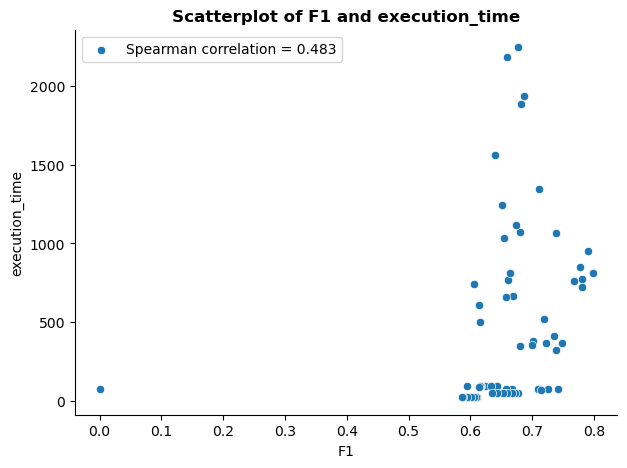

In [129]:
scatter_metrics_plot(model_selection_df, 'F1', 'execution_time')

In [130]:
def print_final_model(df: pd.DataFrame, model_order: int = 0):
    
    final_model_name, fs_model_name = df.loc[model_order, 'tuned_model_name'], df.loc[model_order, 'fs_model_name']
    final_model, final_features = df.loc[model_order, 'tuned_model'], df.loc[model_order, 'final_features']
    final_threshold, final_hyperparameters = df.loc[model_order, 'threshold'], final_model.get_params()

    print(f"Final model: {final_model_name.upper()}")
    print(f"Final model trained on features selected by: {fs_model_name.upper()}")
    print(f"Final subset of features: {', '.join(final_features)}")
    print(f"The final threshold: {final_threshold}")
    print("Final hyperparameters:")

    for hp_name, hp_value in final_hyperparameters.items():
        print(f"{(len('Final hyperparameters:') + 2) * ' '}{hp_name}: {hp_value}")

In [131]:
print_final_model(model_selection_df)

Final model: GRADIENT BOOSTING CLASSIFIER
Final model trained on features selected by: K NEIGHBORS CLASSIFIER
Final subset of features: LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG, DELINQ, CLAGE, CLNO, DEBTINC
The final threshold: 0.5072397285348902
Final hyperparameters:
                        ccp_alpha: 0.0
                        criterion: squared_error
                        init: None
                        learning_rate: 0.01855909395835132
                        loss: exponential
                        max_depth: 10
                        max_features: 1
                        max_leaf_nodes: None
                        min_impurity_decrease: 0.0
                        min_samples_leaf: 1
                        min_samples_split: 2
                        min_weight_fraction_leaf: 0.0
                        n_estimators: 1000
                        n_iter_no_change: None
                        random_state: 42
                        subsample: 1.0
              

Joining the training and validation set for final model building for an evaluation.
- Since we already used the information from validation set within model selection, we increase the training size for model in order to boost the model performance.
- We also filter the final features on which the final model was trained.

In [132]:
def data_filter_join(hyp_tuning_df: pd.DataFrame, x_train: pd.DataFrame,
                     x_valid: pd.DataFrame, x_test: pd.DataFrame,
                     y_train: pd.Series, y_valid: pd.Series,
                     model_order:int = 0) -> tuple[pd.Series, pd.DataFrame, pd.DataFrame]:
    
    #Final features
    final_features = [feat for feat in hyp_tuning_df.loc[model_order, "final_features"]]

    #Joined training and validation labels.
    y_train_valid = pd.concat((y_train, y_valid))

    #Filtered joined training and validation set based on final features.
    x_train_valid_filtered = pd.concat((x_train, x_valid))[final_features]
    
    #Filtered test set based on final features.
    x_test_filtered = x_test[final_features]

    return (y_train_valid, x_train_valid_filtered, x_test_filtered)

In [133]:
y_train_valid, X_train_valid_binned_filtered, X_test_binned_filtered = data_filter_join(model_selection_df, X_train_binned, X_valid_binned,
                                                                                        X_test_binned, y_train, y_valid)

Exporting the final preprocessed data (only with the selected features)

In [134]:
preprocessed = prep_data_export((X_train_valid_binned_filtered, X_test_binned_filtered),
                                    (y_train_valid, y_test),
                                    ("Training_Validation", "Test"),
                                    csv_name = "preprocessed_data")

**Final model building (for evaluation)**
- on the joined training and validation set

In [135]:
def final_model_fit_eval(hyp_tuning_df: pd.DataFrame,
                    x_fit: pd.DataFrame, y_fit: pd.Series,
                    model_order: int = 0,
                    save_models: list[bool, bool, bool] = [True, True, True]):

  
    output_path = "./models/objects_FINAL"

    #Final model
    final_model = hyp_tuning_df.loc[model_order, "tuned_model"]

    #Fitting the final model on the joined training and validation set
    final_model.fit(x_fit, y_fit)

    #Saving the final objects - Final model, Final SFS object, Final FS tuned model
    if save_models[0]:
        fs_model = hyp_tuning_df.loc[model_order, "fs_model"]
        with open(f"{output_path}/fs_tuned_model.h5", "wb") as mod_save:
            pickle.dump(fs_model, mod_save)

    if save_models[1]:
        sfs_model = hyp_tuning_df.loc[model_order, "sfs_object"]
        with open(f"{output_path}/sfs_object.h5", "wb") as mod_save:
            pickle.dump(sfs_model, mod_save)
        
    if save_models[2]:
        final_model = hyp_tuning_df.loc[model_order, "tuned_model"]
        with open(f"{output_path}/final_model_eval.h5", "wb") as mod_save:
            pickle.dump(final_model, mod_save)

    return final_model

Final model

In [136]:
final_model = final_model_fit_eval(model_selection_df, X_train_valid_binned_filtered, y_train_valid)

In [137]:
final_model

GradientBoostingClassifier(criterion='squared_error',
                           learning_rate=0.01855909395835132,
                           loss='exponential', max_depth=10, max_features=1,
                           n_estimators=1000, random_state=42)

Final features

In [138]:
def get_final_features(model_selection_df: pd.DataFrame, model_order: int = 0) -> tuple[float, list]:

    final_features = model_selection_df.loc[model_order, "final_features"]
    
    return final_features

In [140]:
final_features = get_final_features(model_selection_df)

In [142]:
', '.join(final_features)

'LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG, DELINQ, CLAGE, CLNO, DEBTINC'

Optimal threshold
- we recalculate the optimal threshold for evaluation based on the joined training and validation set.

In [141]:
opt_threshold = calc_opt_threshold(final_model, X_train_valid_binned_filtered, y_train_valid)

In [143]:
opt_threshold

0.4071519756778784

## **EVALUATION**

- done on test set

Confusion matrix
- using optimal threshold instead of default 0.5 threshold

The model can distinguish between the defaulters and non-defaulters pretty well.

Confusion matrix

In [145]:
def conf_mat(model, X: pd.DataFrame, y: pd.Series, threshold: float) -> pd.DataFrame:

    y_scores = pd.Series(model.predict_proba(X)[:, 1])
    y_preds = y_scores.apply(lambda x: 1 if x > threshold else 0)

    confm = pd.DataFrame(
                         confusion_matrix(y, y_preds),
                         columns = ["Predicted - Non-Default", "Predicted - Default"],
                         index = ["Actual - Non-Default", "Actual - Default"]
                        )
    return confm

In [146]:
conf_matrix = conf_mat(final_model, X_test_binned_filtered, y_test, opt_threshold)
conf_matrix

,Predicted - Non-Default,Predicted - Default
Actual - Non-Default,686,30
Actual - Default,38,140


In [147]:
def conf_mat_plot(conf_matrix: pd.DataFrame, export:bool = True):
    
    plt.figure(figsize = (9, 7))
    plt.title("Confusion matrix", size = 13, fontweight = "bold")
    sns.heatmap(conf_matrix,
                annot = True, cmap = "BuPu", fmt = "g")
    if export:
        os.makedirs("./plots", exist_ok = True)
        plt.savefig(f"./plots/Confusion_Matrix.jpg", dpi = 300)
    plt.show()

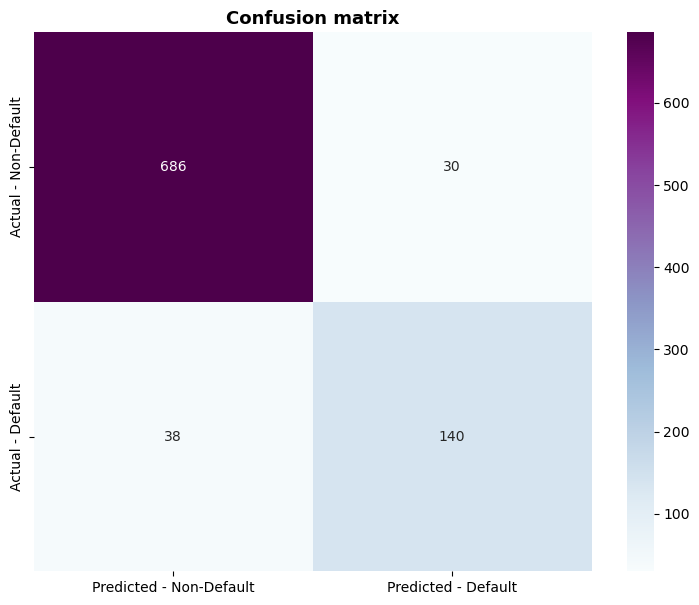

In [148]:
conf_mat_plot(conf_matrix)

In [6]:
os.getcwd()

'c:\\Users\\ngnpe\\OneDrive\\Desktop\\VŠE\\FFÚ - INŽENÝRSKÉ STUDIUM 2020-2023\\FFÚ - DIPLOMOVÁ PRÁCE\\thesis'

In [15]:
from sklearn.metrics import classification_report

with open(r'..\FFU_VSE_Masters_Thesis_ML_Credit_Risk_Modelling\models\objects_FINAL\final_model_eval.h5', 'rb') as f:
    final_model = pickle.load(f)


data = pd.read_csv(r'..\FFU_VSE_Masters_Thesis_ML_Credit_Risk_Modelling\data\preprocessed_data.csv')
threshold = 0.4071519756778784
data = data[data['set'] == 'Test']
data = data.drop('set',axis=1)
X = data.drop('BAD',axis=1)
y = data['BAD']
y_probs = final_model.predict_proba(X)[:,1]
y_preds = pd.Series(y_probs).apply(lambda x: 1 if x > threshold else 0)
print(classification_report(y, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       716
           1       0.82      0.79      0.80       178

    accuracy                           0.92       894
   macro avg       0.89      0.87      0.88       894
weighted avg       0.92      0.92      0.92       894



In [17]:
evaluation_metrics(final_model, X, y, threshold)

,Metric,Score
0,F1,0.804598
1,Precision,0.823529
2,Recall,0.786517
3,Accuracy,0.923937
4,AUC,0.955527
5,Somers D,0.911054
6,KS,0.788510
7,MCC,0.757715
8,Jaccard Score,0.673077
9,Brier Score Loss,0.061669


Calculating other metrics

In [16]:
def evaluation_metrics(model, X: pd.DataFrame, y: pd.Series,
                       threshold: float, target: str = "BAD") -> pd.DataFrame:

    metrics = {
                "F1": f1_score,
                "Precision": precision_score, 
                "Recall": recall_score, 
                "Accuracy": accuracy_score,
                "AUC": roc_auc_score,
                "Somers D": somersd,
                "KS": ks_2samp, 
                "MCC": matthews_corrcoef,
                "Jaccard Score": jaccard_score,
                "Brier Score Loss": brier_score_loss,
                "Zero-One Loss": zero_one_loss,
                "Hamming Loss": hamming_loss
                }


    probs_evs = ["AUC","Brier Score Loss"]
    class_evs = ["Precision", "Recall", "F1", "Accuracy", "MCC", "Zero-One Loss", "Jaccard Score", "Hamming Loss"]
    evs_list = []

    y_scores = model.predict_proba(X)[:, 1]
    y_preds = pd.Series(y_scores).apply(lambda x: 1 if x > threshold else 0)
    
    for metric_name, metric in metrics.items():
        if metric_name in probs_evs:
            evs_list.append([metric_name, metric(y, y_scores)])
        elif metric_name in class_evs:
            evs_list.append([metric_name, metric(y, y_preds)])
        elif metric_name == "Somers D":
            evs_list.append([metric_name, metric(y, y_scores).statistic])
        elif metric_name == "KS":
            X_Y_concat = pd.concat((y, X), axis = 1)
            X_Y_concat["prob"] =  y_scores
            evs_list.append([metric_name, metric(X_Y_concat.loc[X_Y_concat[target] == 1, "prob"],
                                                 X_Y_concat.loc[X_Y_concat[target] == 0, "prob"]).statistic])

    evaluation_df = pd.DataFrame(evs_list, columns = ["Metric", "Score"])

    return evaluation_df

In [150]:
evaluation_metrics(final_model, X_test_binned_filtered, y_test, opt_threshold)

,Metric,Score
0,F1,0.804598
1,Precision,0.823529
2,Recall,0.786517
3,Accuracy,0.923937
4,AUC,0.955527
5,Somers D,0.911054
6,KS,0.788510
7,MCC,0.757715
8,Jaccard Score,0.673077
9,Brier Score Loss,0.061669


ROC curve

In [151]:
def ROC_curve_plot(model, X: pd.DataFrame, y: pd.Series, export:bool = True):
    y_pred = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    plt.figure(figsize = (10, 7))
    plt.plot(fpr,tpr,label=f"AUC = {auc*100:.2f}%")
    plt.plot([0, 1], [0, 1], "r--")
    plt.ylabel("True Positive Rate",  size = 11)
    plt.xlabel("False Positive Rate",  size = 11)
    plt.xticks(size = 11)
    plt.yticks(size = 11)
    plt.title("ROC curve", size = 13, fontweight = "bold")
    plt.legend()
    plt.grid()
    axes = plt.gca()
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)

    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/ROC_curve_FINAL.jpg", dpi = 300)
    plt.show()

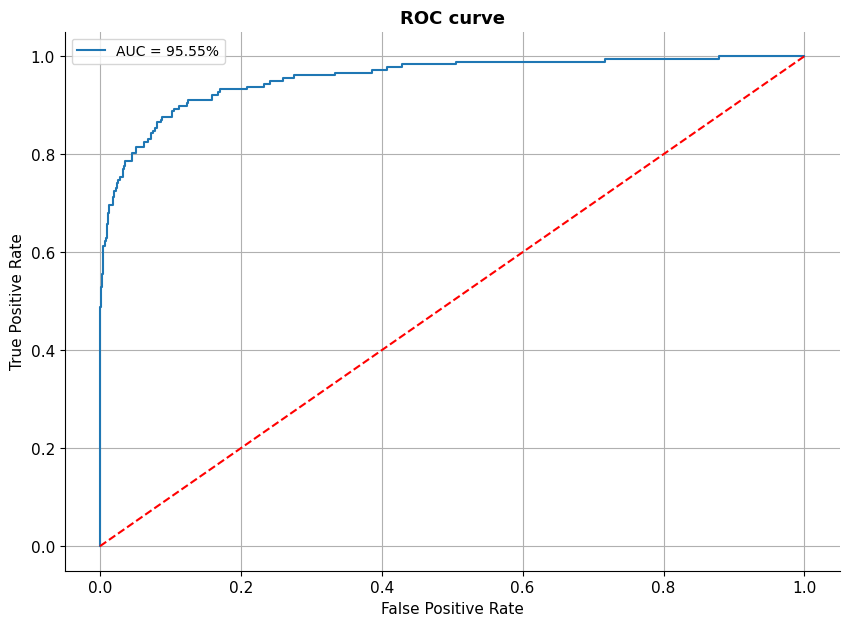

In [152]:
ROC_curve_plot(final_model, X_test_binned_filtered, y_test)

Feature importances

In [ ]:
def feature_importance_plot(model, features: list, export:bool = True):
    
    importances = model.feature_importances_

    plot_df = pd.DataFrame({"Features": features, "Importances": importances})
    plot_df = plot_df.sort_values("Importances", ascending = False)

    plt.figure(figsize = (10, 6))
    sns.barplot(plot_df, x = "Importances", y = "Features", palette = "BuPu_r")
    plt.title("Feature Importances", fontsize = 15, fontweight = "bold")

    axes = plt.gca()
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)

    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/Feature_Importances.jpg", dpi = 300)
        
    plt.show()

In [ ]:
feature_importance_plot(final_model, final_features)

SHAP values

In [ ]:
def GBC_SHAP_plot(model, X: pd.DataFrame, export: bool = True):

    shap_values = shap.TreeExplainer(model).shap_values(X)

    #Scaling the SHAP values in order to be between -1 and 1.
    max_abs_shap = np.max(np.abs(shap_values))
    scaled_shap_values = shap_values / max_abs_shap

    fig, ax = plt.subplots(figsize=(13,16))

    shap.summary_plot(scaled_shap_values,
                      X.values,
                      feature_names = X.columns,
                      show = False)
    plt.title("SHAP Summary per Feature", fontsize = 15, fontweight = "bold")

    if export:
        os.makedirs("./plots/", exist_ok = True)
        plt.savefig(f"./plots/SHAP_summary_plot.jpg", dpi = 1200)

    plt.show()

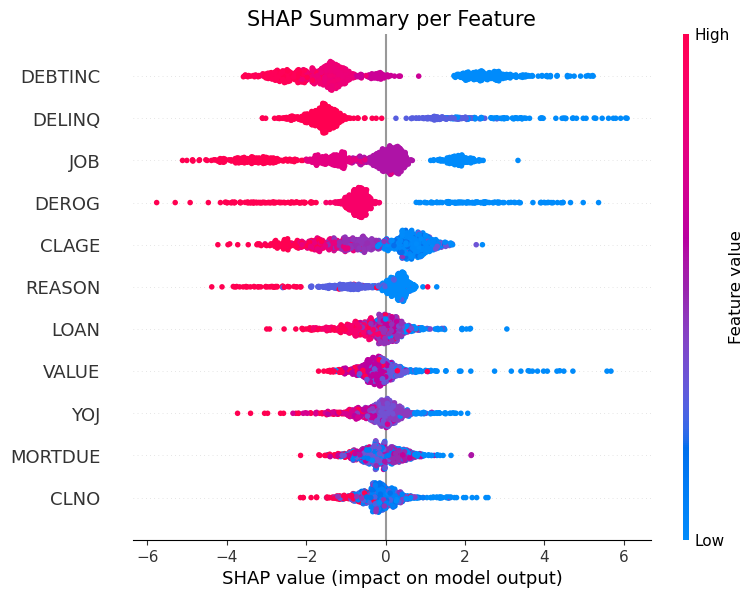

In [153]:
GBC_SHAP_plot(final_model, X_test_binned_filtered)

Final model fitting ready for deployment.
- since we already used an information from test set within model evaluation, we increase the training size by joining the training, validation and test set in order to boost model performance in deployment.
- we also recalculate the final threshold based on the joined training, validation and test set.

In [157]:
def final_model_fit_deploy(final_model, X: tuple, y: tuple, final_features: list, target = 'BAD', export: bool = True):

    df_list = []
    output_path = "./models/objects_FINAL"

    #Joining the features and labels from training, validation and test sets.
    for feat, lab in zip(X, y):
        temp = pd.concat((lab, feat), axis = 1)
        df_list.append(temp)
    dfs = [df for df in df_list]

    #Final model fit.
    final_df = pd.concat(dfs, axis = 0).sort_index()
    X_final = final_df[final_features]
    y_final = final_df[target]

    final_model.fit(X_final, y_final)
    
    #Exporting the final model.
    if export:
        with open(f"{output_path}/final_model_deploy.h5", "wb") as mod_save:
            pickle.dump(final_model, mod_save)

    #Final classification threshold
    final_threshold = calc_opt_threshold(final_model, X_final, y_final)

    return (final_model, final_threshold)

In [158]:
final_model_deployment, final_threshold_deployment = final_model_fit_deploy(final_model,
                                                                            (X_train_valid_binned_filtered, X_test_binned),
                                                                            (y_train_valid, y_test),
                                                                            final_features)

In [4]:
final_threshold_deployment

0.516215955223872

We also export required inputs for ML application in deployment
- Available bins and their WoE's
- Optbinning transformator
- Final model
- Final features
- Final threshold
- List of categorical features
- Empty input data frame

In [249]:
def flask_app_input_export(**kwargs):

    with open(f"./flask_app/inputs/inputs_flask_app_dict.pkl", "wb") as f:
        pickle.dump(kwargs, f)

In [250]:
flask_app_input_export(woe_bins = woe_bins,
                       binning_transformator = binning_transformator,
                       final_model = final_model_deployment,
                       threshold = final_threshold_deployment,
                       final_features = final_features,
                       categorical_features = cat_vars,
                       input_df = pd.DataFrame(columns = X_train_binned.columns))

Such ML web application is available here: http://defaultprediction-petrngn.pythonanywhere.com/